# Hyperskill python dataset analysis

## Settings

In [17]:
import pandas as pd
import numpy as np

from typing import List, Dict
import string
import sys

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid', font_scale=2, rc={"lines.linewidth": 5, "lines.markersize": 15})

In [18]:
import importlib
import attrs
import statistics
import plots

importlib.reload(attrs)
importlib.reload(statistics)
importlib.reload(plots)

from attrs import draw_base_attrs

from statistics import get_submissions_percent_by_issues, get_client_stats, \
    get_submissions_series_dynamic_by_feature, get_submissions_series_issues_dynamic, \
    get_top_issues, get_submissions_percent_by_feature, \
    get_submissions_series_client_dynamic

from plots import draw_compare, draw_heatmap_compare, \
    draw_hist_plots, draw_count_plots, \
    draw_stat_plot, draw_client_dynamic_graph

difficulty
easy -> medium -> hard


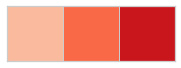

complexity
shallow -> middle -> deep


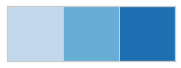

level
low -> average -> high


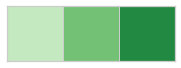

client
idea -> web


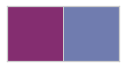

In [19]:
draw_base_attrs()

In [20]:
def merge_dfs(df_left: pd.DataFrame, df_right: pd.DataFrame, left_on: str, right_on: str) -> pd.DataFrame:
    df_merged = pd.merge(df_left, df_right, left_on=left_on, right_on=right_on, suffixes=('', '_extra'))
    df_merged.drop(df_merged.filter(regex='_extra$').columns.tolist(), axis=1, inplace=True)
    return df_merged

### Set path to following csv files (or use preset default)

In [81]:
users_file_path = '../data/java/users.csv'
steps_file_path = '../data/python/steps.csv'
topics_file_path = '../data/python/topics.csv'

submissions_file_path = '../data/python/result_solutions_python_with_series_full.csv'
submissions_stats_file_path = '../data/python/result_submissions_stats_python.csv'
client_stats_file_path = '../data/python/client_stats_python.csv'

raw_issues_stats_file_path = '../data/python/raw_issues_stats.csv'
qodana_issues_stats_file_path = '../data/python/qodana_issues_stats.csv'
raw_issues_classes_file_path = '../data/python/raw_issues.csv'
qodana_issues_classes_file_path = '../data/python/qodana_issues.csv'

## Steps and Topics
**Step** - is a task where user is asked to write some code. Main attributes:
* `id` - *identifier of step*
* `seconds_to_complete` - *estimated secons to complete (calculated as average from all successful sumbissions)*
* `solved_by` - *number of successful sumbissions*
* `success_rate` - *number of successful sumbissions dvided by total number of sumbissions*
* `topic_id` - *id of topic step is related to*
* `complexity` - [`shallow`, `middle`, `deep`] *according to topic depth [d<=3, 3<d<6, d>=6]*
* `difficulty` - [`easy`, `medium`, `hard`] *according to success_rate [sr<=0.33, 0.33<sr<0.66, sr>=0.66]*

**Topic** - is a theme or knowledge area. Every step is related to some topic. Main attributes:
* `id` - *identifier of step*
* `prerequisites` - *topics ids which must be leared before*
* `depth` - *the depth in topics tree*

In [27]:
df_steps = pd.read_csv(steps_file_path)
df_steps.describe().astype('int32')

id  lesson_stepik_id  position  seconds_to_complete  solved_by  \
count    765               765       765                  765        765   
mean    9049            326362         4                  226       5081   
std     2365             97036         3                  185       8875   
min     5205            201305         1                   40          9   
25%     7109            247201         1                  109        526   
50%     8558            294759         5                  169       1844   
75%    10361            378890         7                  279       5727   
max    15247            576423        11                 1598      81289   

       stepik_id  success_rate  topic  topic_theory  depth  
count        765           765    765           735    765  
mean     1182391             0    724          8610      5  
std       460855             0    308          2411      2  
min       586801             0    333          5204      0  
25%       789319             0    467          6315      4  
50%      1047910             0    616          8077      5  
75%      1444936             0    923         10209      7  
max      2342184             0   1585         15181     10

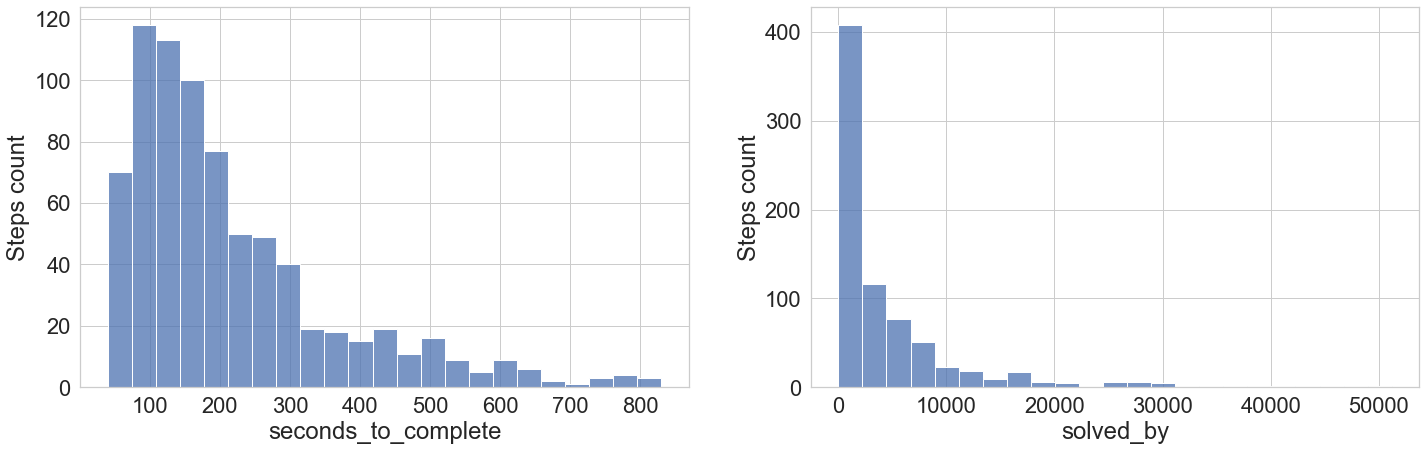

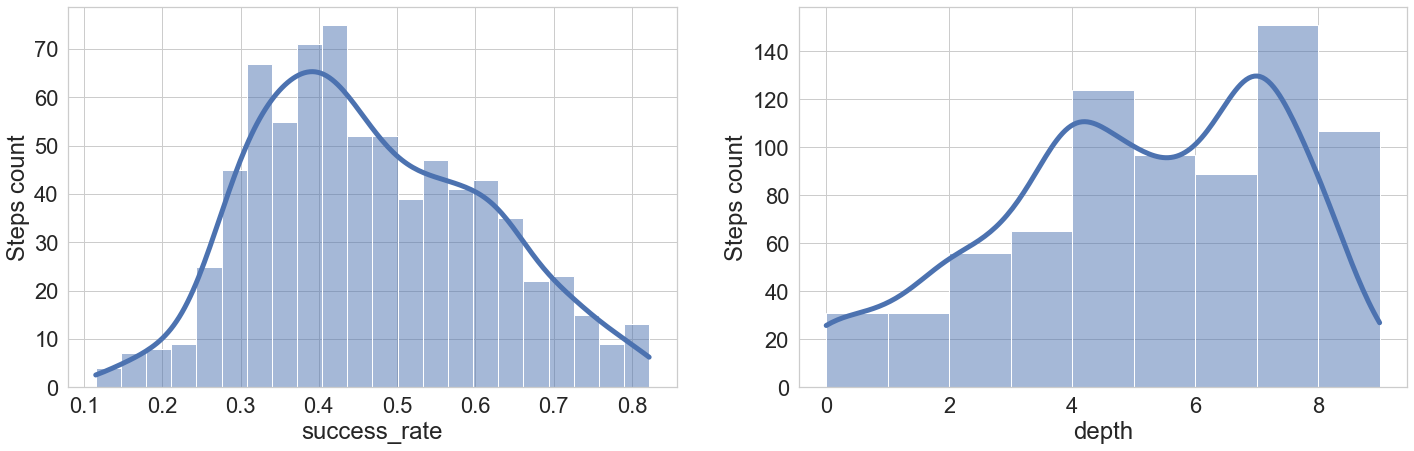

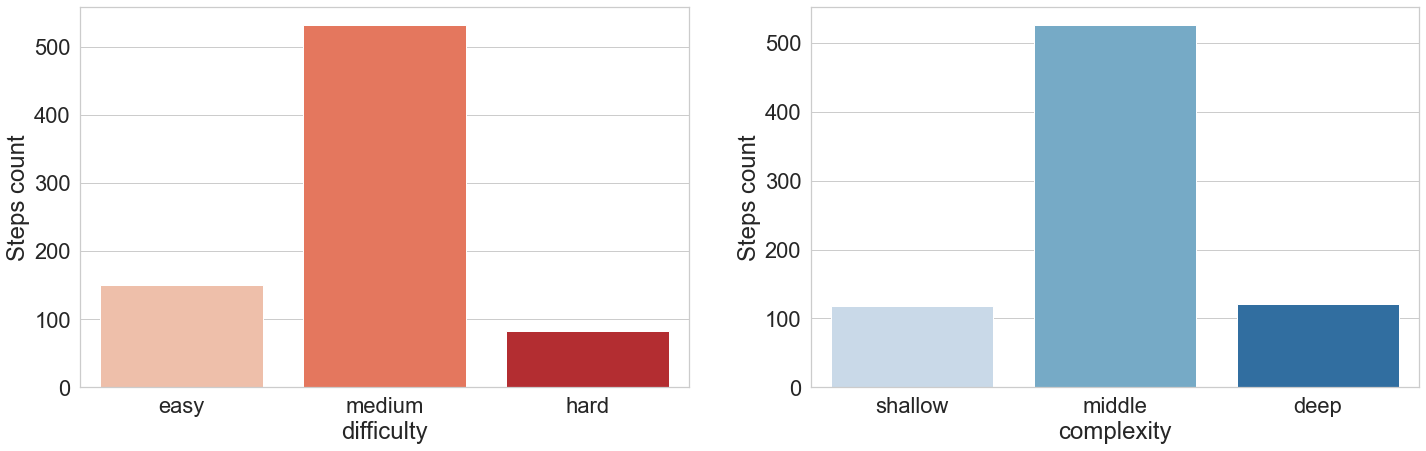

In [28]:
draw_hist_plots(df_steps, ['seconds_to_complete', 'solved_by'], log_scale=False, y_label='Steps count')
draw_hist_plots(df_steps, ['success_rate', 'depth'], log_scale=False, kde=True, y_label='Steps count')
draw_count_plots(df_steps, ['difficulty',  'complexity'], y_label='Steps count')

## Users

* `id` - *identifier of user*
* `passed_theories` - *number of passed theories steps*
* `passed_problems` - *number of passed problems*
* `passed_topics` - *number of passed topics*
* `passed_stages` - *number of passed stages*
* `passed_projects` - *number of passed projects*
* `hypercoins` - *number of collected hypercoins*
* `active_days` - *number of active days*
* `max_streak` - *max streak*
* `level` - `[low, avg, high]` *according to passed_topics [tp<=20, 20<tp<40, tp>=40]*

In [29]:
df_users = pd.read_csv(users_file_path)
df_users.describe().astype('int32')

id  passed_theories  passed_problems  passed_topics  passed_stages  \
count  37626            37626            37626          37626          37626   
mean   19236               46              226             46              7   
std    11815               74              446             75             18   
min        0                0                0              0              0   
25%     9486                7               14              3              0   
50%    18978               16               60             16              2   
75%    28480               53              233             56              7   
max    82397             1143             8834           1155            525   

       passed_projects  hypercoins  active_days  max_streak  
count            37626       37626        37626       37626  
mean                 1         297           16           5  
std                  3         634           36          14  
min                  0           0            0           0  
25%                  0          27            2           1  
50%                  1         140            4           2  
75%                  1         293           16           5  
max                109       28201          680         715

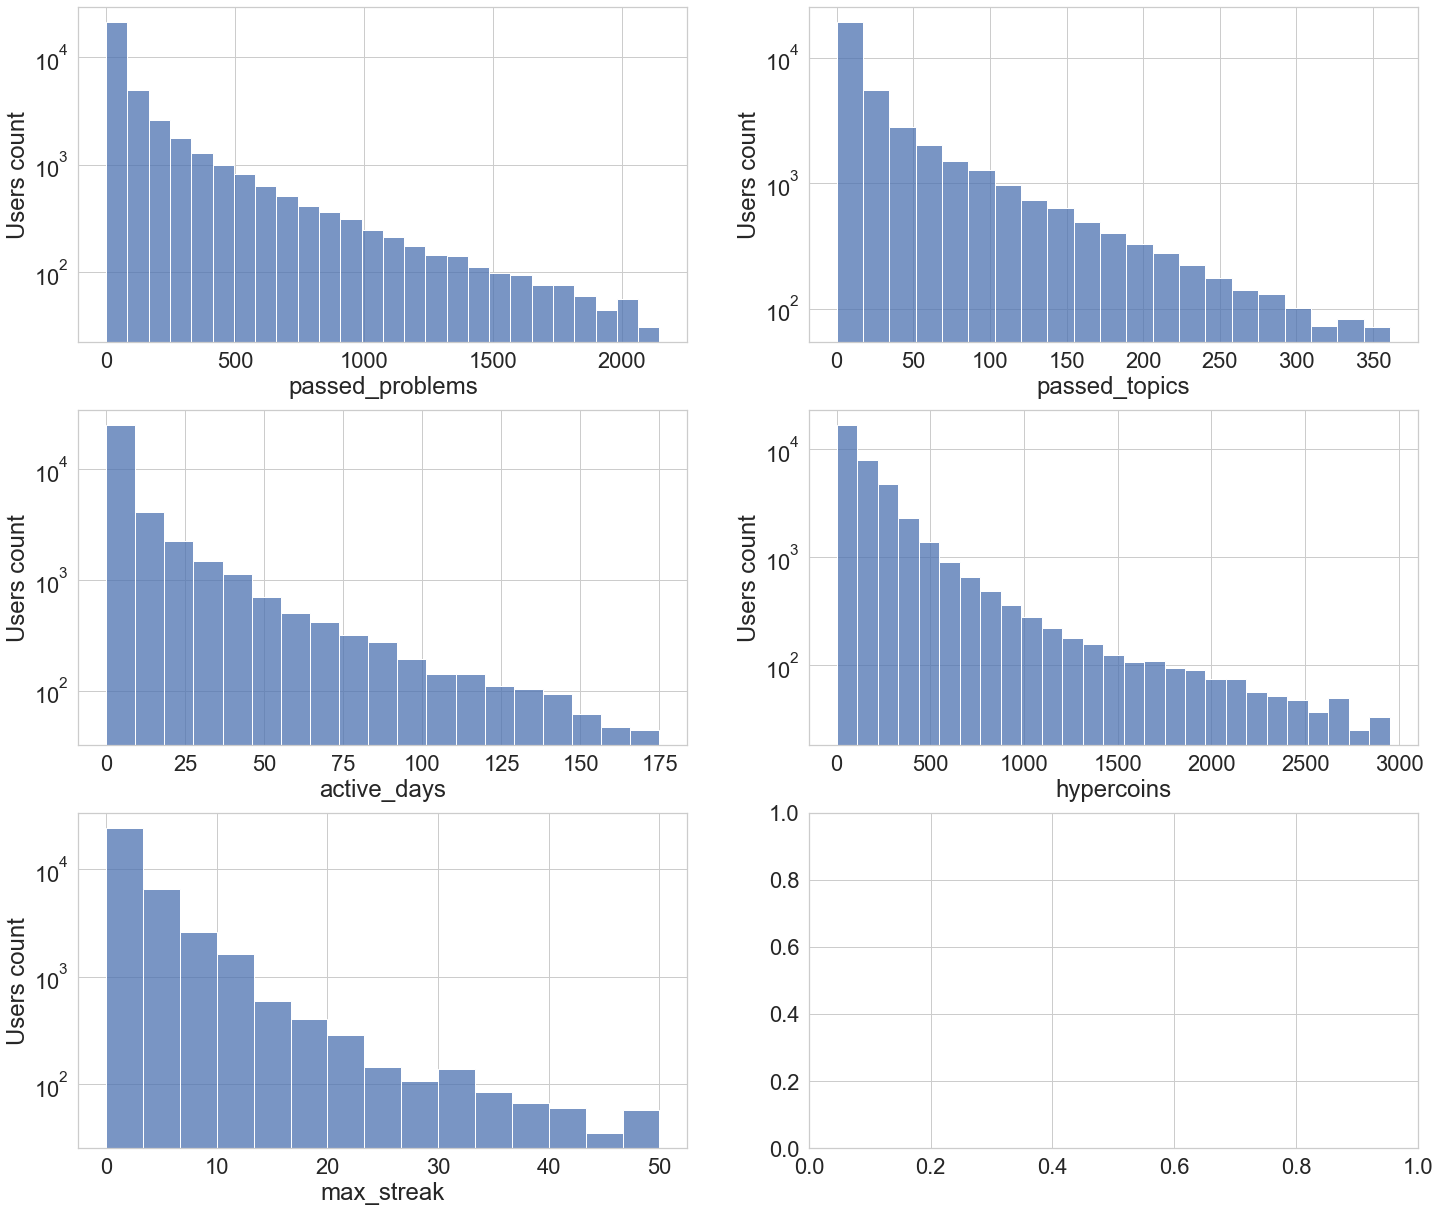

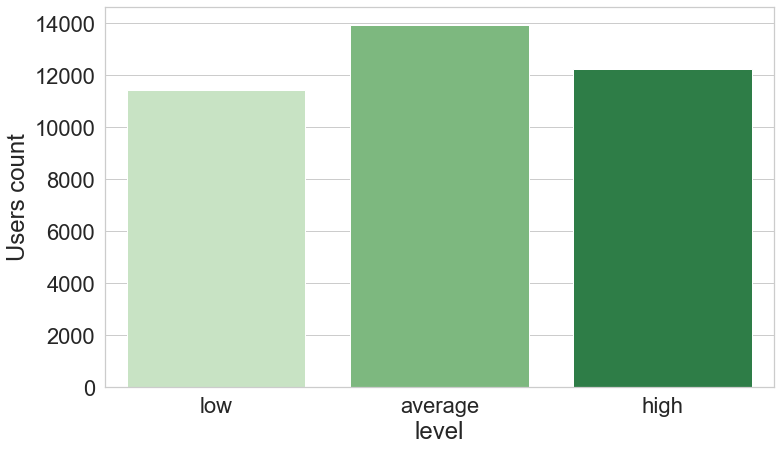

In [30]:
draw_hist_plots(df_users, ['passed_problems', 'passed_topics', 
                           'active_days', 'hypercoins', 
                           'max_streak'], log_scale=(False, True), y_label='Users count')
draw_count_plots(df_users, ['level'], y_label='Users count')

## Submissions
Total number of submissions: 1459860\
Number of filtered submissions: 1411218 (without automatic resubmissions and suspicious submissions [too different from previous])

* `id` - *identifier of submission*
* `step_id` - *identifier of step*
* `user_id` - *identifier of user*
* `group` - *number of submission series (group of submissions on one step by one user)*
* `attempt` - *number of attempt inside submission series*
* `total_attempt` - *number of attempts is submission series*
* `base_client` - `[web, idea, ide, IdeaEdu, Idea]` *interface from which submission was submitted*
* `client` - `[web, idea]` *interface group from which submission was submitted*

In [42]:
df_submissions = pd.read_csv(submissions_file_path)
df_submissions.describe().astype('int32')

id  step_id  attempt  sync_counter  user_id    group  \
count   2115153  2115153  2115153       2115153  2115153  2115153   
mean   42724957     7461       14             4    49485   838360   
std     7739819     1575      122             0    19099   511452   
min    29381317     5205        1             1        2        0   
25%    35950338     6465        1             4    42138   390097   
50%    42742312     6895        1             5    52352   838447   
75%    49493011     8439        1             5    62394  1282041   
max    56397785    15247     3359            19    82400  1722704   

       total_attempts  
count         2115153  
mean               27  
std               211  
min                 1  
25%                 1  
50%                 1  
75%                 2  
max              3359

### Sumbission client distriburion


<AxesSubplot:xlabel='client', ylabel='Count'>

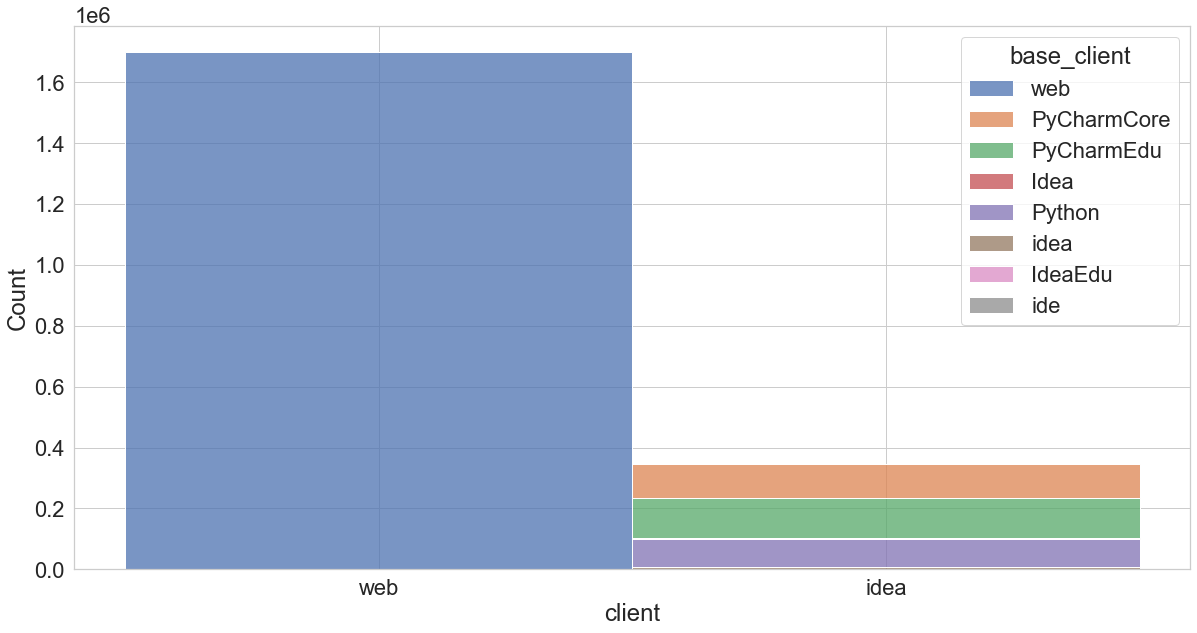

In [43]:
fig, ax = plt.subplots(figsize=((20, 10)))
sns.histplot(data=df_submissions, x='client', hue='base_client', multiple='stack')

## Submission statistics
* `code_lines_count` - number of code lines
* `code_symbols_count` - number of code symbols
* `raw_issues_count` - number of raw issues
* `qodana_issues_count` - number of qodana issues
* `raw_issues_by_code_lines` - number of raw issues divided by code lines
* `qodana_issues_by_code_lines` - number of qodana issues divided by code lines

In [49]:
df_submissions_stats = pd.read_csv(submissions_stats_file_path)
df_submissions_stats.to_csv(submissions_stats_file_path, index=False)
df_submissions_stats.describe()

id  code_symbols_count  qodana_issues_count  \
count  2.115153e+06        2.115153e+06         2.115153e+06   
mean   4.272496e+07        1.352890e+02         6.851987e-03   
std    7.739820e+06        1.263055e+02         9.993420e-02   
min    2.938132e+07        8.000000e+00         0.000000e+00   
25%    3.595034e+07        5.400000e+01         0.000000e+00   
50%    4.274231e+07        9.800000e+01         0.000000e+00   
75%    4.949301e+07        1.750000e+02         0.000000e+00   
max    5.639778e+07        4.948000e+03         1.100000e+01   

       raw_issues_count  code_lines_count  
count      2.115153e+06      2.115153e+06  
mean       1.421333e+00      6.626800e+00  
std        2.735540e+00      4.739915e+00  
min        0.000000e+00      1.000000e+00  
25%        0.000000e+00      3.000000e+00  
50%        0.000000e+00      5.000000e+00  
75%        2.000000e+00      8.000000e+00  
max        5.010000e+02      1.470000e+02

In [50]:
df_submissions_stats = merge_dfs(df_submissions_stats, df_submissions, left_on='id', right_on='id')
df_submissions_stats = merge_dfs(df_submissions_stats, df_steps[['id', 'complexity', 'difficulty']], left_on='step_id', right_on='id')
df_submissions_stats = merge_dfs(df_submissions_stats, df_users[['id', 'level']], left_on='user_id', right_on='id')

In [51]:
df_submissions_stats['raw_issues_by_code_lines'] = df_submissions_stats['raw_issues_count'] / df_submissions_stats['code_lines_count']
df_submissions_stats['qodana_issues_by_code_lines'] = df_submissions_stats['qodana_issues_count'] / df_submissions_stats['code_lines_count']

In [57]:
df_submissions_stats['raw_issues_count'].unique()

array([ 1,  0,  4,  3,  6,  2, 10, 14,  8, 21,  7,  5, 11,  9, 13, 15, 19,
       17, 29, 12, 22, 16, 20, 18, 25, 45, 31, 35, 27, 41, 38, 34, 23, 81,
       51, 30, 24, 28, 26, 33, 36, 32, 37, 52, 48, 39, 59, 42, 75, 60, 53])

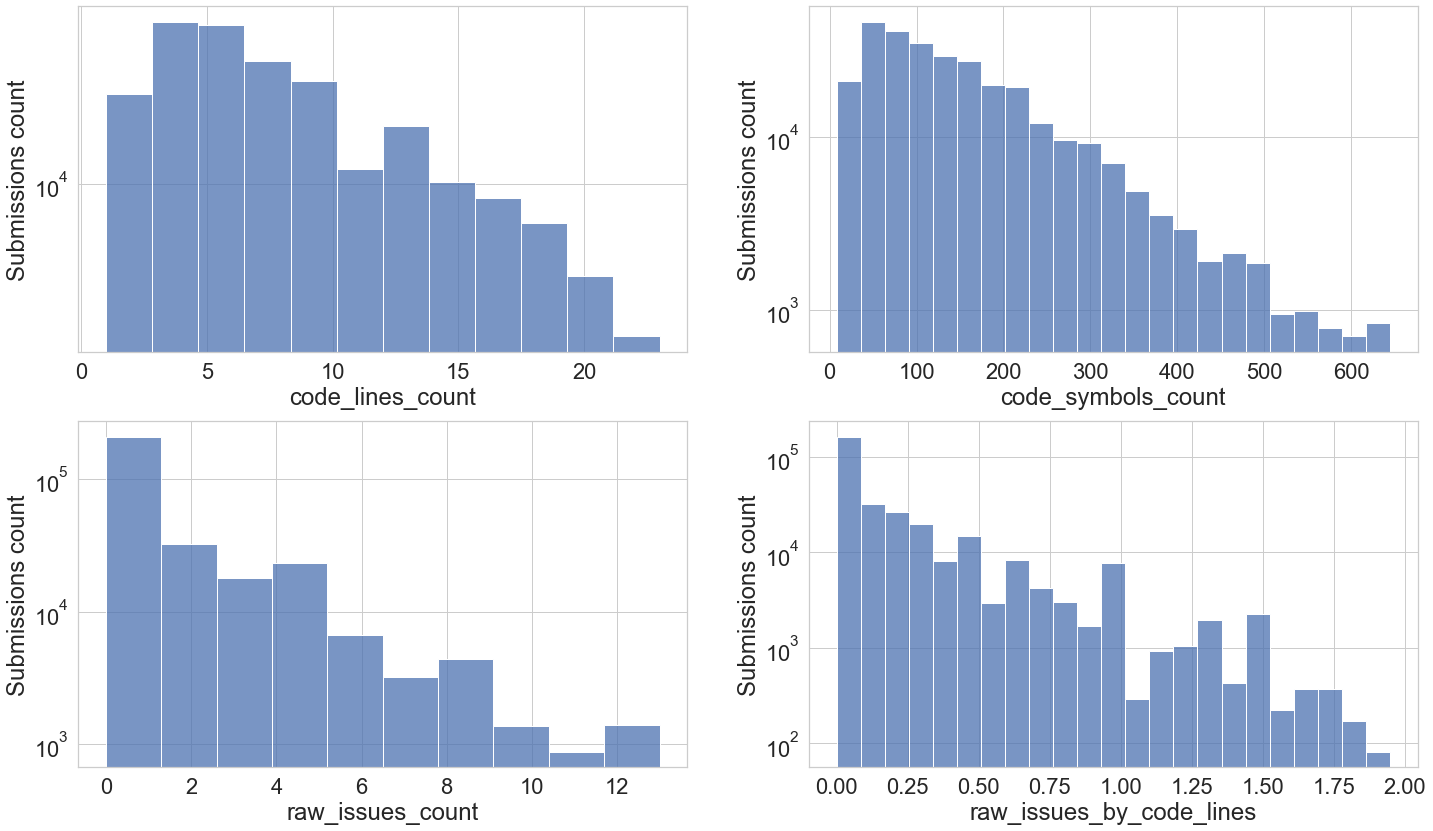

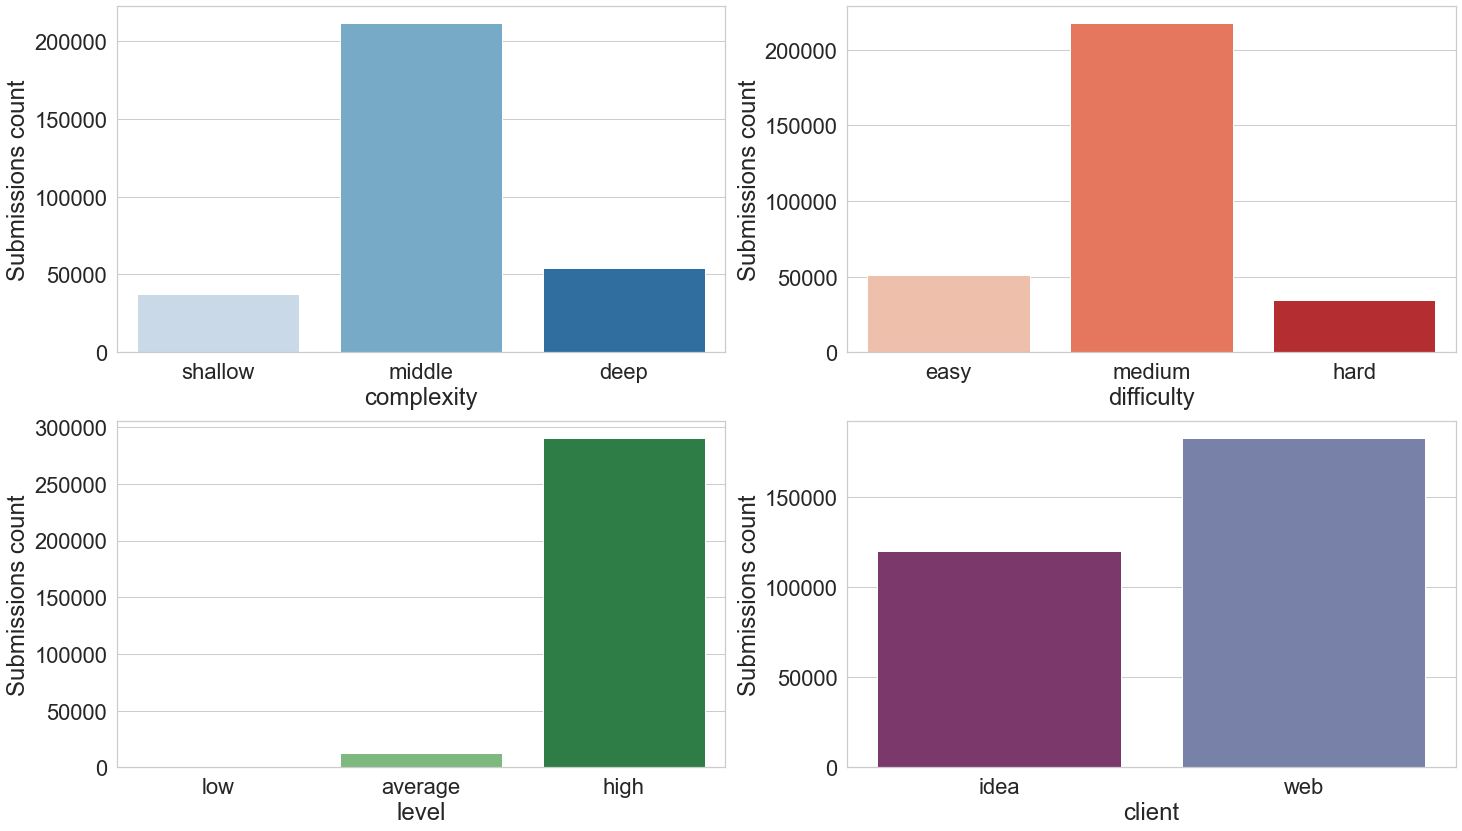

In [58]:
draw_hist_plots(df_submissions_stats, ['code_lines_count', 'code_symbols_count', 
                                       'raw_issues_count', 'raw_issues_by_code_lines'], 
                log_scale=(False, True), y_label='Submissions count')

draw_count_plots(df_submissions_stats, ['complexity', 'difficulty', 'level', 'client'], y_label='Submissions count')

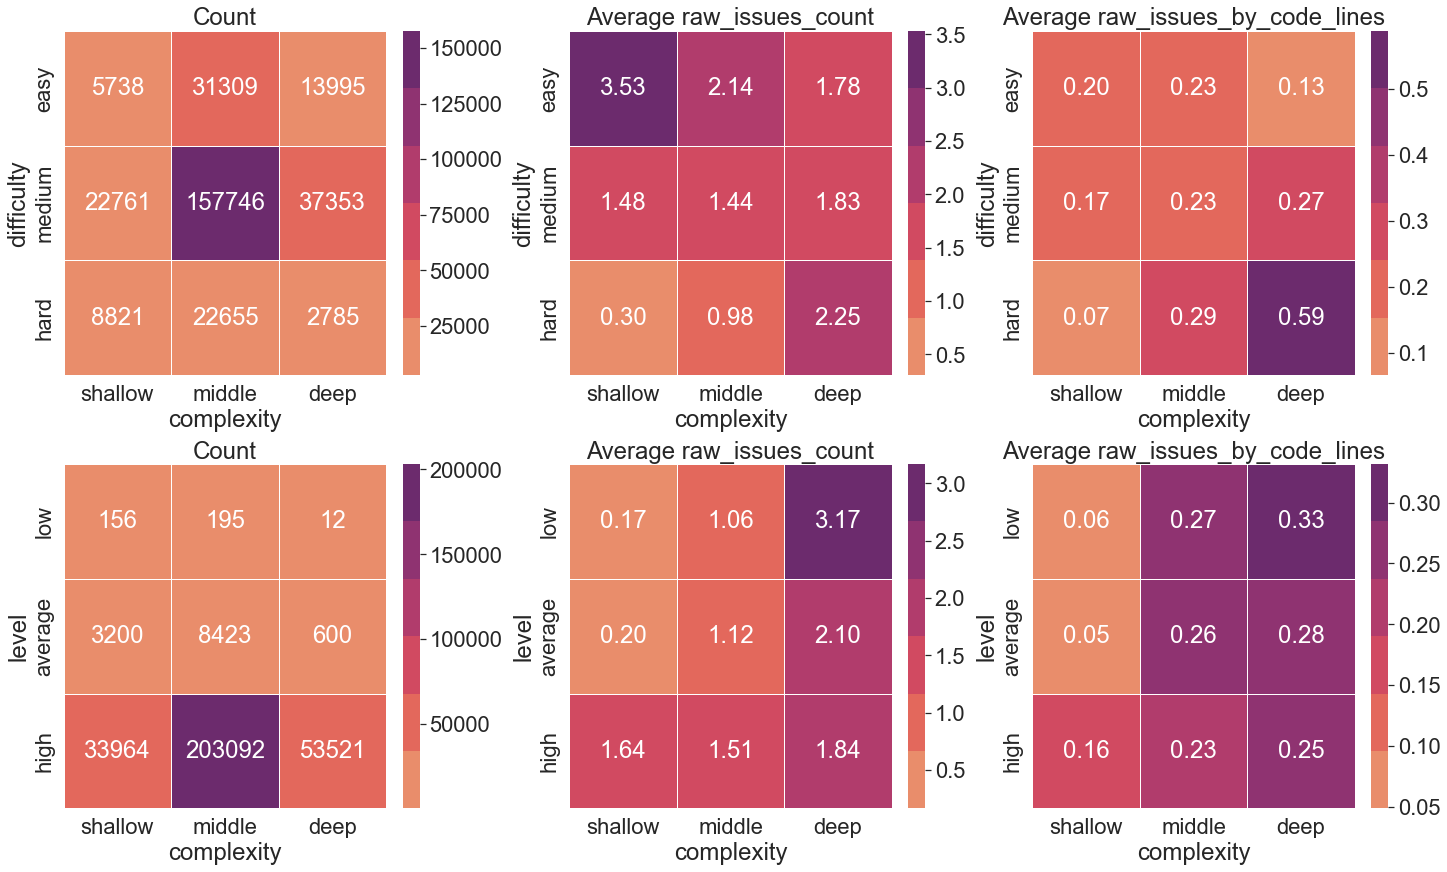

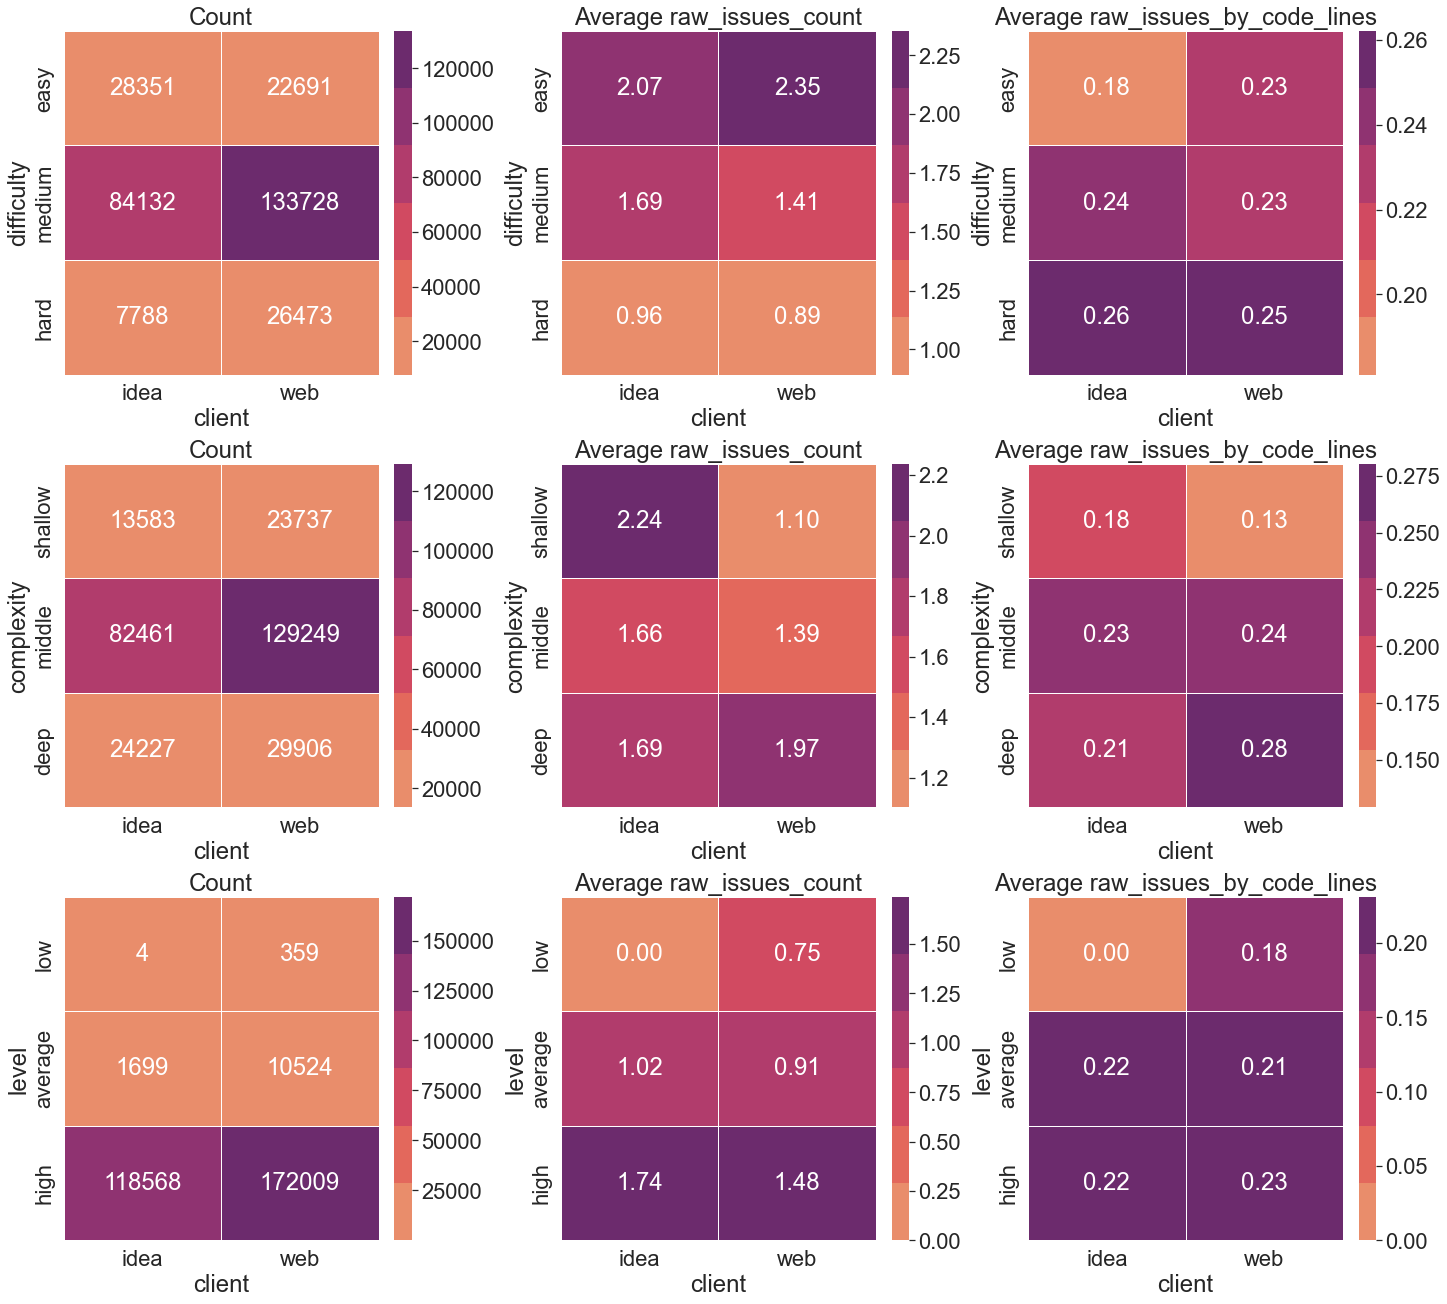

In [59]:
draw_heatmap_compare(df_submissions_stats, 
                     [('difficulty', 'complexity'), ('level', 'complexity')],
                     ['id', 'raw_issues_count', 'raw_issues_by_code_lines'])
draw_heatmap_compare(df_submissions_stats,
                     [('difficulty', 'client'), ('complexity', 'client'), ('level', 'client')],
                     ['id', 'raw_issues_count', 'raw_issues_by_code_lines'])

### Submissions percent distribution according to feature values

In [60]:
def draw_feature(feature: str, feature_range: List[float]):
    for attr in ['difficulty', 'complexity', 'level', 'client']:
        df_feature_stats = get_submissions_percent_by_feature(df_submissions_stats, feature, attr, feature_range)
#         uncomment to save stats to csv
#         df_feature_stats.to_csv(f'feature_stats_{attr}.csv', index=False)
        draw_compare(df_feature_stats, feature, attr)

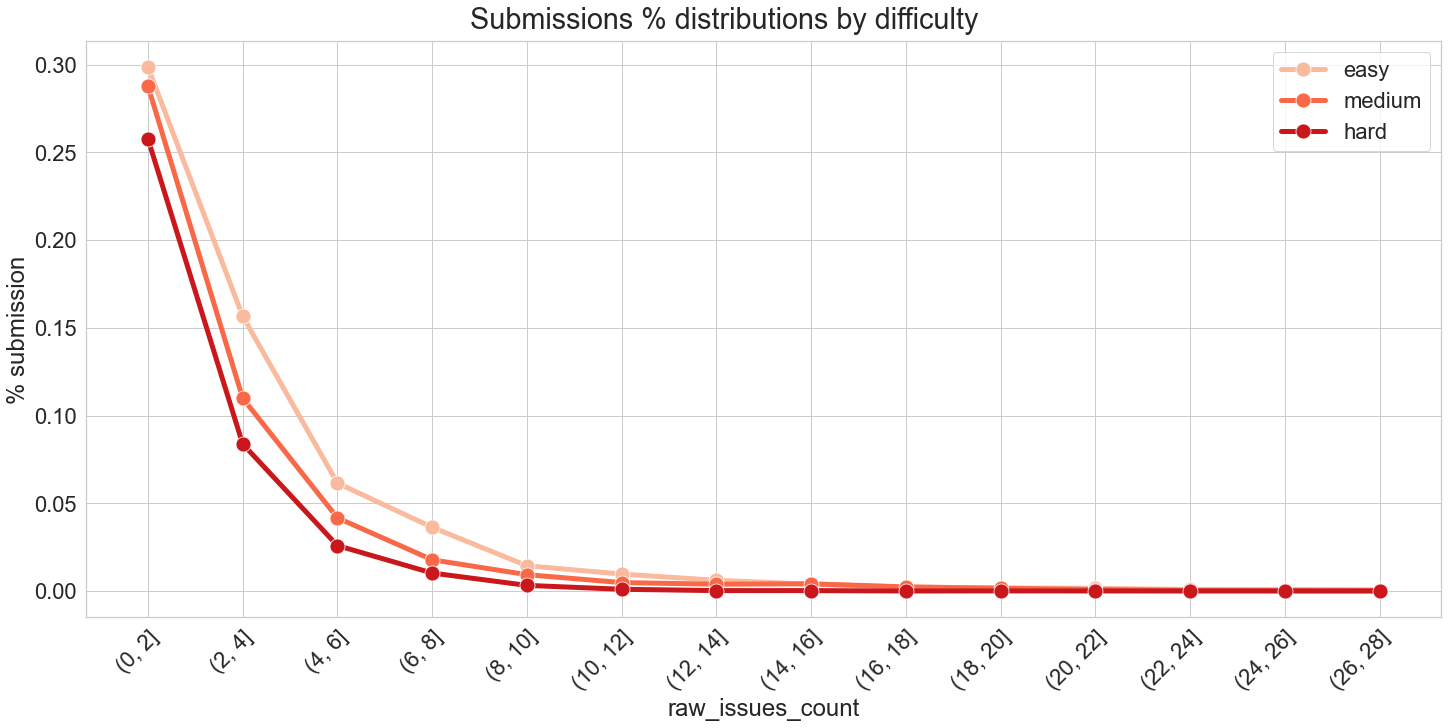

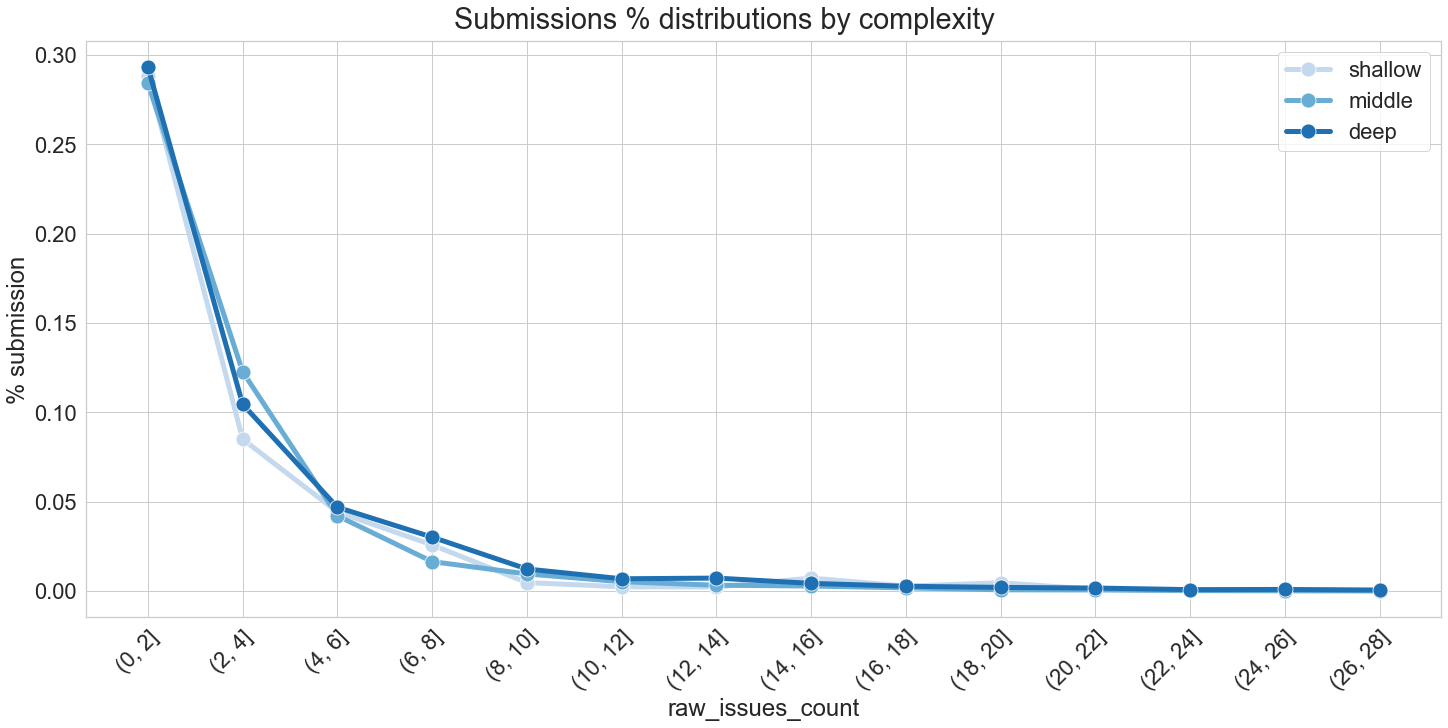

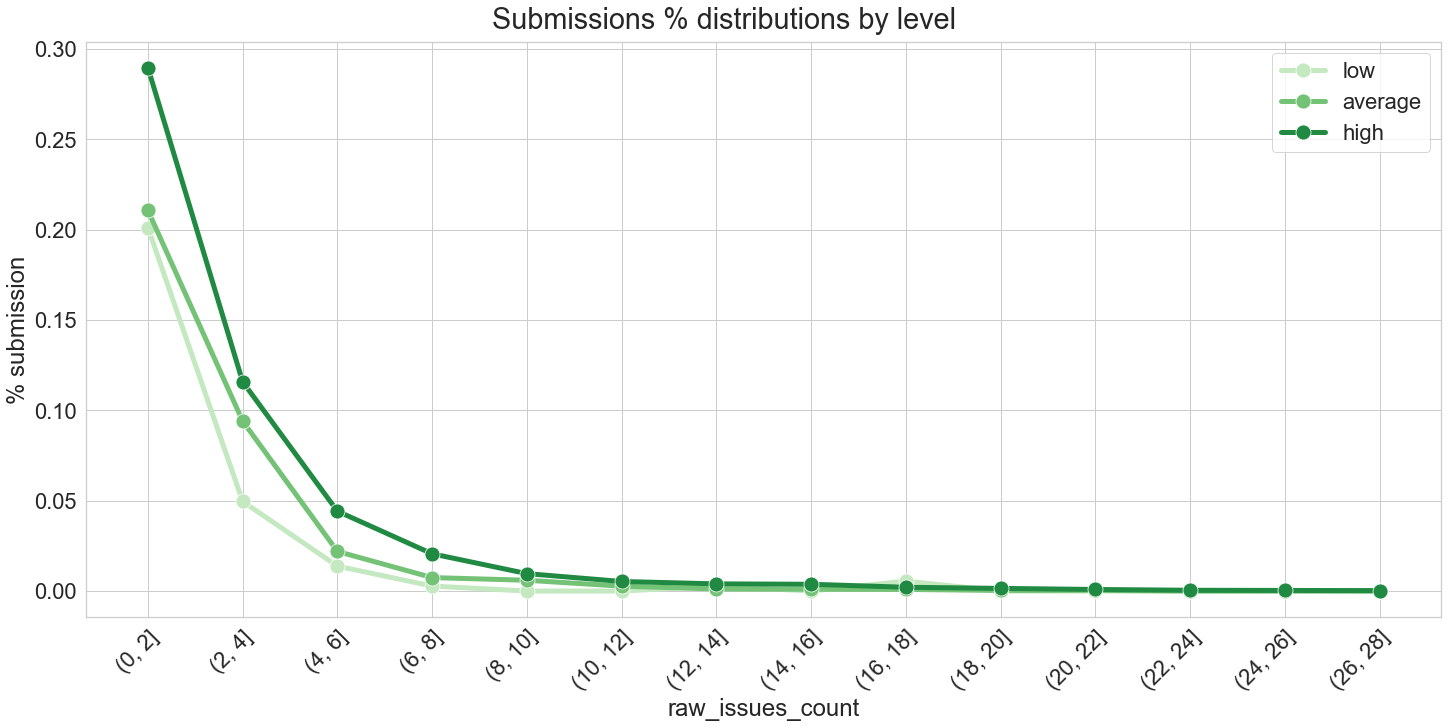

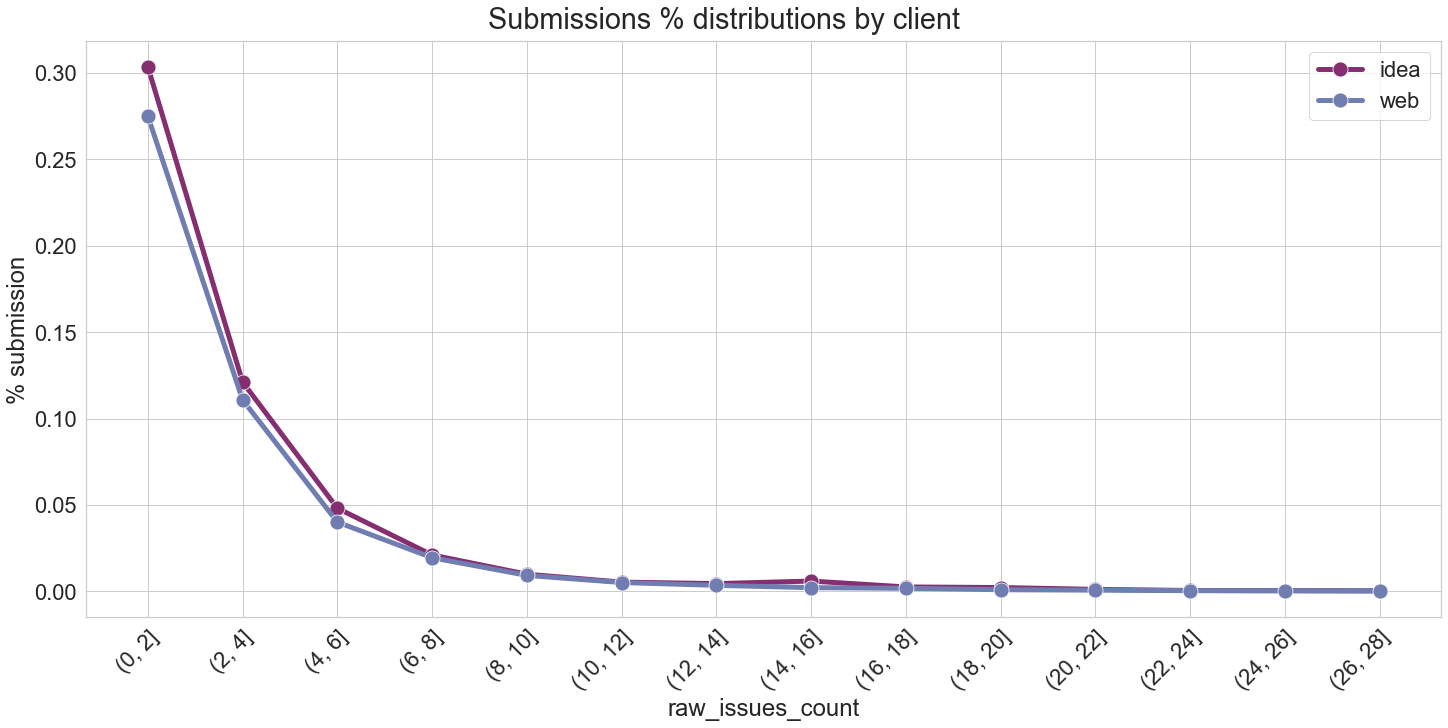

In [61]:
draw_feature('raw_issues_count', range(0, 30, 2))

# Issues

Issue is code quality error which has `class` e.x. MagicNumberCheck and `type` e.x. INFO.
Each submission has number of `raw_issues` detected by Hyperstyle and `qodana_issues` detected by Qodana. 

In [62]:
def draw_issues(df: pd.DataFrame, df_issues: pd.DataFrame, blur_issues):
    for attr in ['difficulty', 'complexity', 'level', 'client']:
        df_stats = get_submissions_percent_by_issues(df, df_issues, attr)
#         uncomment to save stats to csv
#         df_stats.to_csv(f'issues_stats_{attr}.csv', index=False)
        draw_compare(df_stats, 'issue', attr, blur_issues)

## Raw issue

In [64]:
df_raw_issues_stats = pd.read_csv(raw_issues_stats_file_path)
df_raw_issues_stats = df_raw_issues_stats[df_raw_issues_stats['id'].isin(df_submissions['id'])]
df_raw_issues_stats.describe()

id        RAD100         W0301          E211          E222  \
count  2.115153e+06  2.115153e+06  2.115153e+06  2.115153e+06  2.115153e+06   
mean   4.272496e+07  8.004149e-04  1.570572e-03  1.362029e-02  5.114051e-03   
std    7.739820e+06  2.828029e-02  5.955010e-02  1.661558e-01  8.722278e-02   
min    2.938132e+07  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    3.595034e+07  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    4.274231e+07  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    4.949301e+07  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    5.639778e+07  1.000000e+00  1.000000e+01  1.700000e+01  7.000000e+00   

             WPS462        WPS322         W1309          F541        WPS237  \
count  2.115153e+06  2.115153e+06  2.115153e+06  2.115153e+06  2.115153e+06   
mean   1.344536e-02  8.164894e-04  5.564609e-04  5.503148e-04  9.917486e-03   
std    1.204531e-01  4.332135e-02  3.212114e-02  3.184779e-02  1.487117e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    1.300000e+01  1.300000e+01  6.000000e+00  6.000000e+00  2.000000e+01   

       ...         W0222         C0412          E401        WPS418  \
count  ...  2.115153e+06  2.115153e+06  2.115153e+06  2.115153e+06   
mean   ...  9.455581e-07  1.796560e-05  9.455581e-07  3.782232e-06   
std    ...  1.375179e-03  5.752758e-03  9.723979e-04  1.944793e-03   
min    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    ...  2.000000e+00  2.000000e+00  1.000000e+00  1.000000e+00   

              E0302          B306         W0129         W1503          B006  \
count  2.115153e+06  2.115153e+06  2.115153e+06  2.115153e+06  2.115153e+06   
mean   9.455581e-07  2.080228e-05  4.727790e-07  1.371059e-05  9.455581e-07   
std    9.723979e-04  4.560905e-03  6.875893e-04  5.370228e-03  1.375179e-03   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  3.000000e+00  2.000000e+00   

             WPS411  
count  2.115153e+06  
mean   9.455581e-07  
std    9.723979e-04  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    1.000000e+00  

[8 rows x 418 columns]

In [65]:
df_raw_issues_stats = merge_dfs(df_raw_issues_stats, df_submissions_stats, left_on='id', right_on='id')

In [66]:
df_raw_issues = pd.read_csv(raw_issues_classes_file_path)
raw_issues_info_classes = [issue['class'] for _, issue in df_raw_issues.iterrows() if issue['type'] == 'INFO']
raw_issues_ignore_classes = []

### Most popular raw issues
In further analysis we will consider only top 15 issues

In [67]:
df_raw_issues_top = get_top_issues(df_raw_issues_stats, df_raw_issues, 15, raw_issues_ignore_classes)
df_raw_issues_top

class            type                                name   count
26    SC200            INFO                 SpellingErrorInName  122362
59   WPS432            INFO                         MagicNumber   57974
119    F821  BEST_PRACTICES                                F821   35374
109   E0602     ERROR_PRONE                               E0602   35368
28   WPS336  BEST_PRACTICES                ExplicitStringConcat   16754
29     E231      CODE_STYLE                 WhitespaceAfter,;:    12239
30     E226      CODE_STYLE  WhitespaceAroundArithmeticOperator   12211
176    H601        COHESION                    LowClassCohesion   10678
146  WPS503  BEST_PRACTICES                UselessReturningElse    7876
16     E225      CODE_STYLE            WhitespaceAroundOperator    7724
13    W0611  BEST_PRACTICES                        UnusedImport    6447
61    SC100            INFO             SpellingErrorInComments    5738
238  WPS515  BEST_PRACTICES           OpenWithoutContextManager    4421
8    WPS237      COMPLEXITY           TooComplexFormattedString    4215
25     E265      CODE_STYLE                   BlockCommentError    3293

In [68]:
# Unique means a flag: 1 if issue presented in submission, 0 otherwise
df_raw_issues_stats_unique = df_raw_issues_stats.copy()
for issue_class in df_raw_issues['class'].values:
    df_raw_issues_stats_unique[issue_class] = df_raw_issues_stats_unique[issue_class].apply(lambda x: min(x, 1))

### Percent of all submissions which contain each raw issue

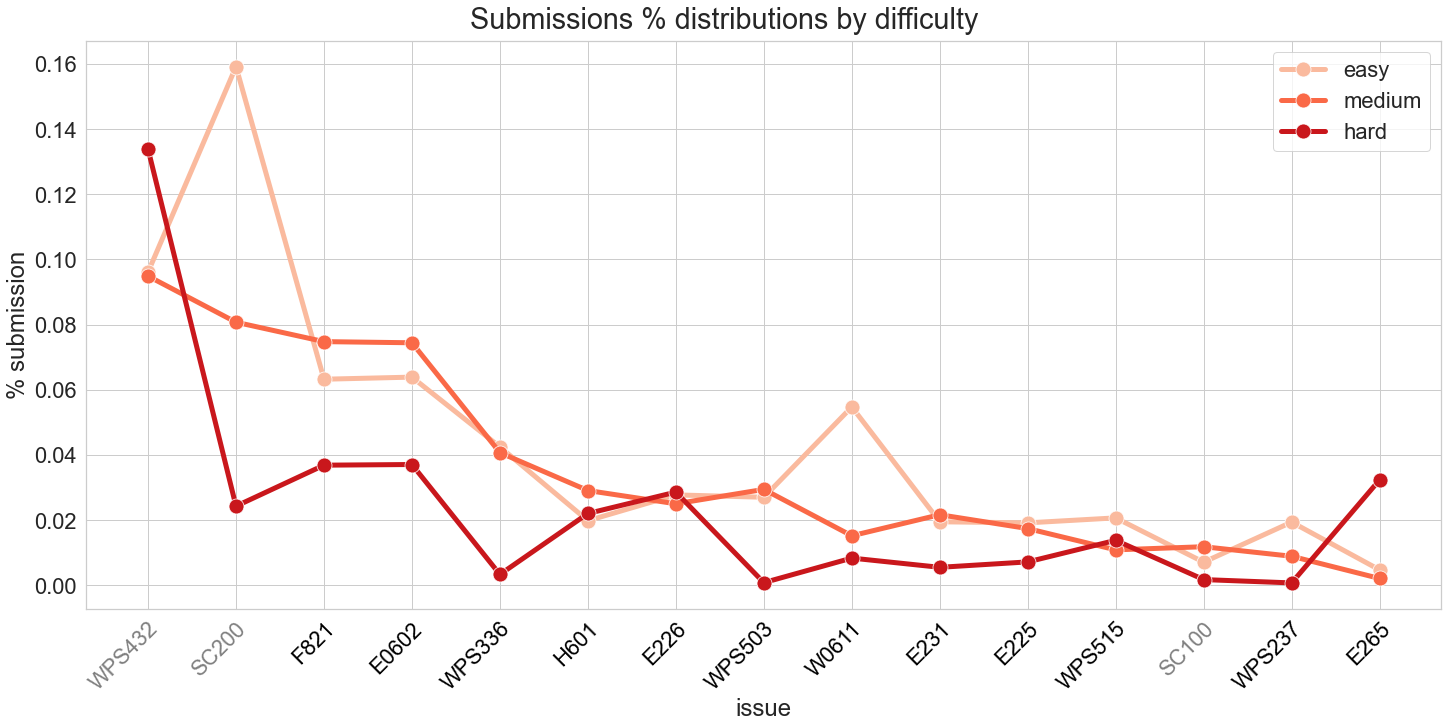

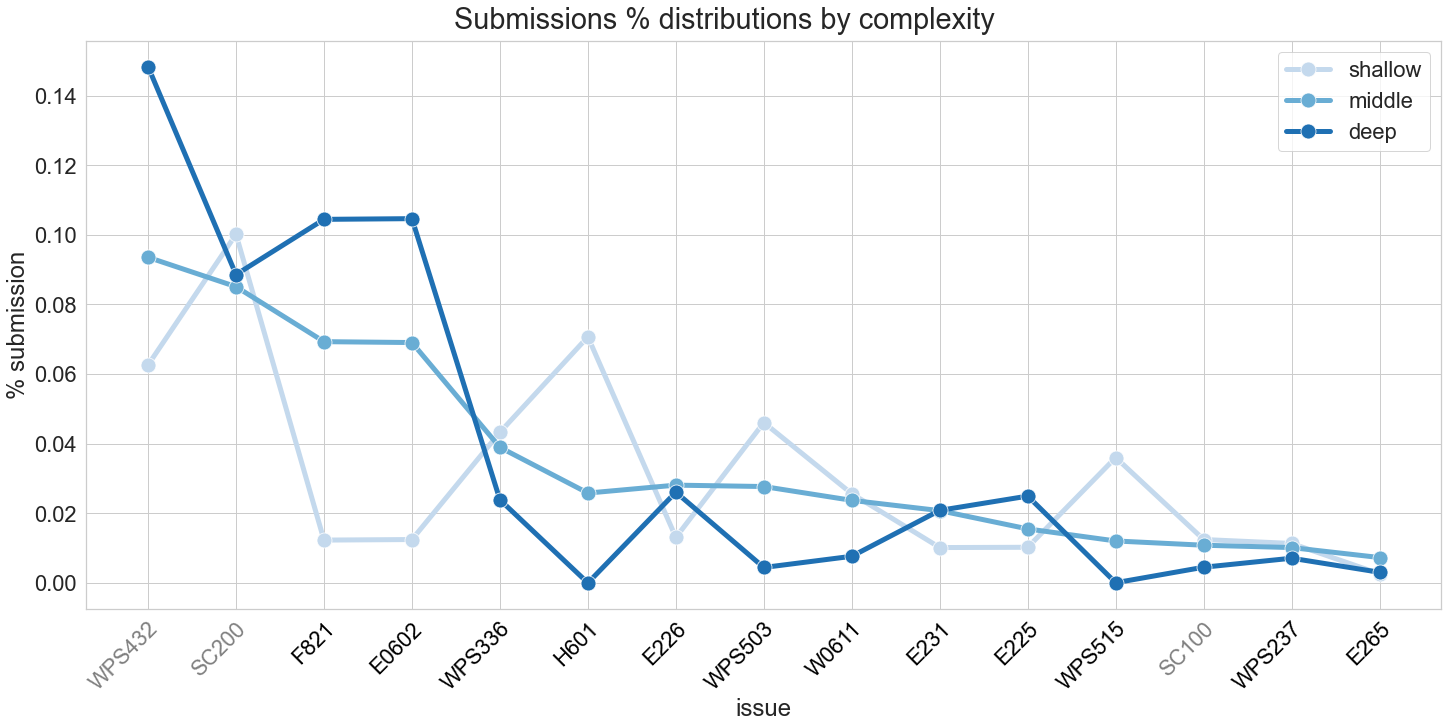

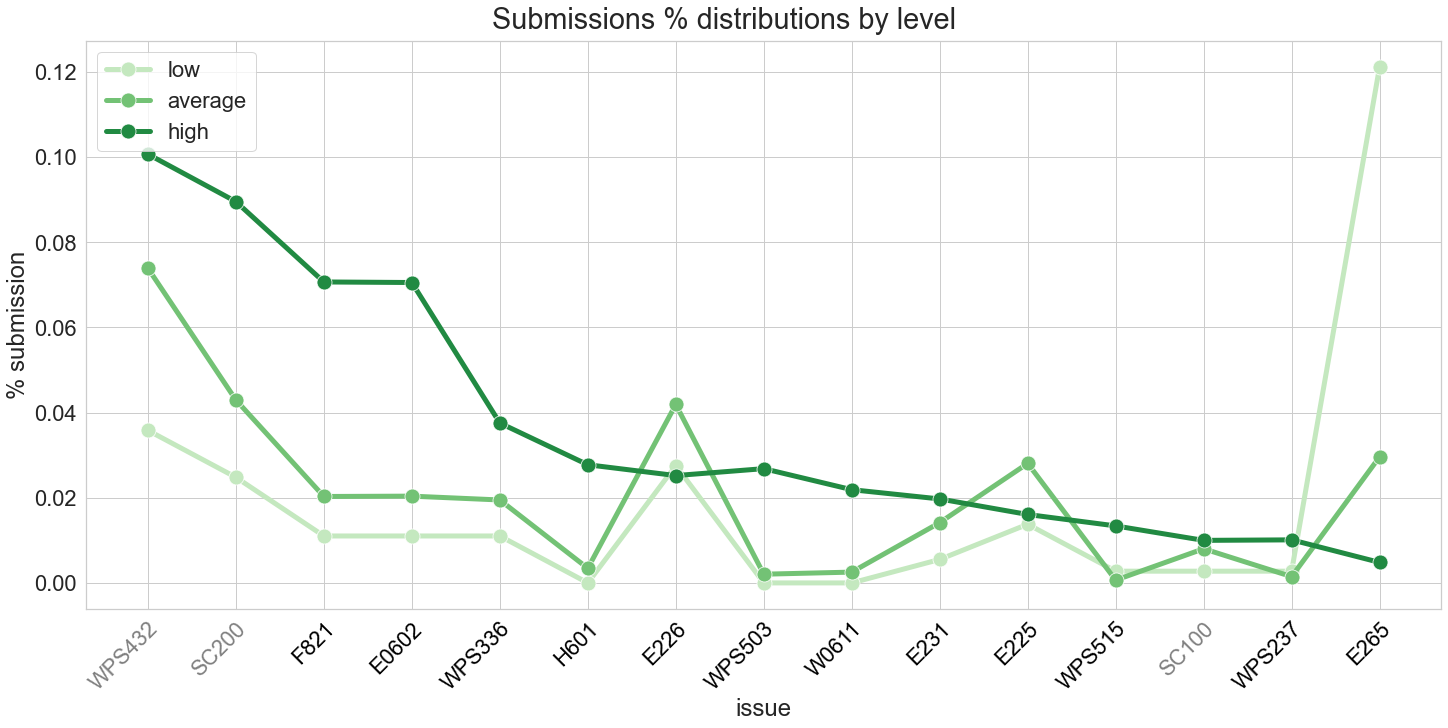

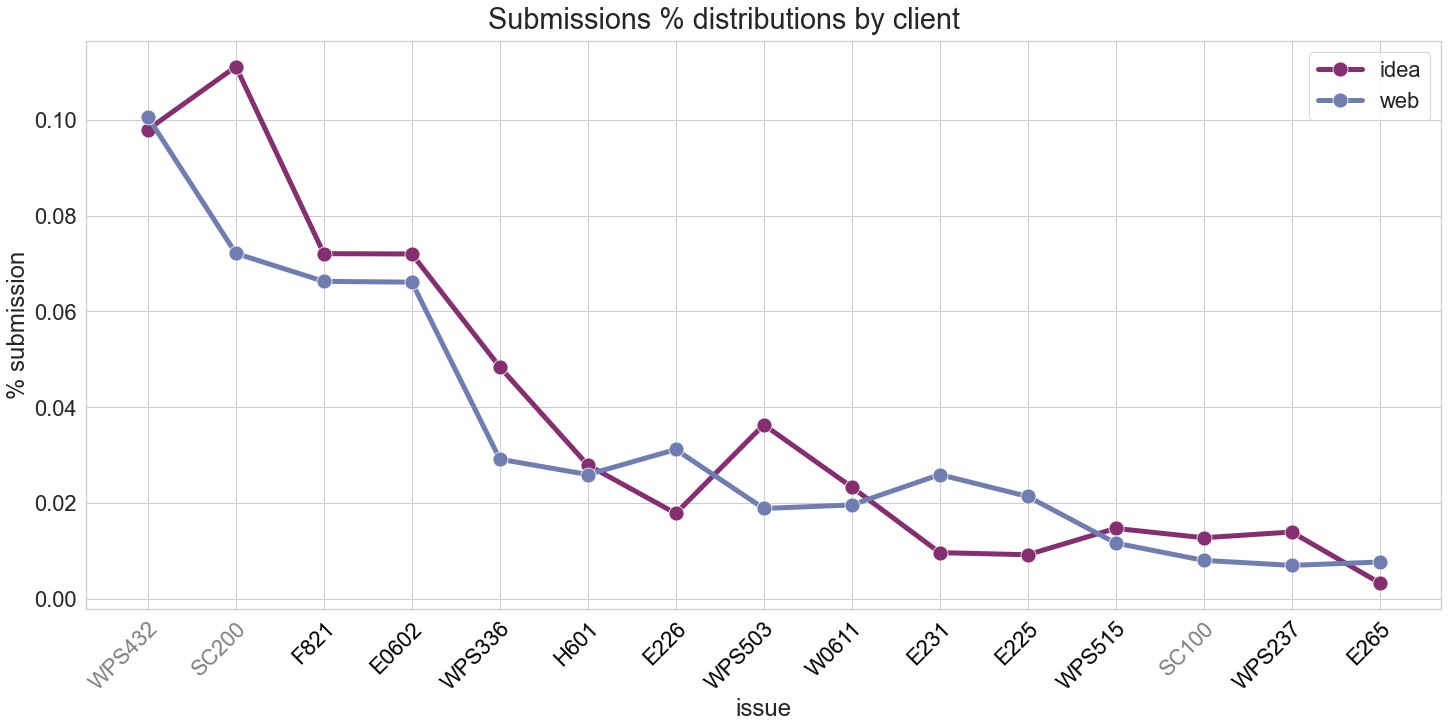

In [69]:
draw_issues(df_raw_issues_stats_unique, df_raw_issues_top, raw_issues_info_classes)

# First attempt stats
First attempt submissions is when **attempt** == 1

In [70]:
df_first_attempt_stats = df_submissions_stats[df_submissions_stats['attempt'] == 1]
df_first_attempt_stats.describe()

id  code_symbols_count  qodana_issues_count  \
count  2.008070e+05       200807.000000        200807.000000   
mean   4.243021e+07          140.791068             0.006897   
std    7.721883e+06          129.180227             0.096177   
min    2.938152e+07            8.000000             0.000000   
25%    3.547589e+07           58.000000             0.000000   
50%    4.228083e+07          107.000000             0.000000   
75%    4.932451e+07          181.000000             0.000000   
max    5.639778e+07         3264.000000            11.000000   

       raw_issues_count  code_lines_count        step_id   attempt  \
count     200807.000000     200807.000000  200807.000000  200807.0   
mean           1.429039          6.812905    7731.092442       1.0   
std            2.627721          4.785368    1693.118665       0.0   
min            0.000000          1.000000    5205.000000       1.0   
25%            0.000000          4.000000    6542.000000       1.0   
50%            0.000000          6.000000    7173.000000       1.0   
75%            2.000000          9.000000    8812.000000       1.0   
max           81.000000         98.000000   15247.000000       1.0   

        sync_counter        user_id         group  total_attempts  \
count  200807.000000  200807.000000  2.008070e+05   200807.000000   
mean        4.707102   14314.986953  1.044451e+05        1.509723   
std         0.972427   11916.221152  8.657515e+04       16.389206   
min         2.000000       2.000000  0.000000e+00        1.000000   
25%         4.000000    4009.000000  5.027450e+04        1.000000   
50%         5.000000   11506.000000  1.012660e+05        1.000000   
75%         5.000000   21121.000000  1.519505e+05        1.000000   
max        19.000000   82097.000000  1.722217e+06     3359.000000   

       raw_issues_by_code_lines  qodana_issues_by_code_lines  
count             200807.000000                200807.000000  
mean                   0.228088                     0.006897  
std                    0.416480                     0.096177  
min                    0.000000                     0.000000  
25%                    0.000000                     0.000000  
50%                    0.000000                     0.000000  
75%                    0.307692                     0.000000  
max                   10.000000                    11.000000

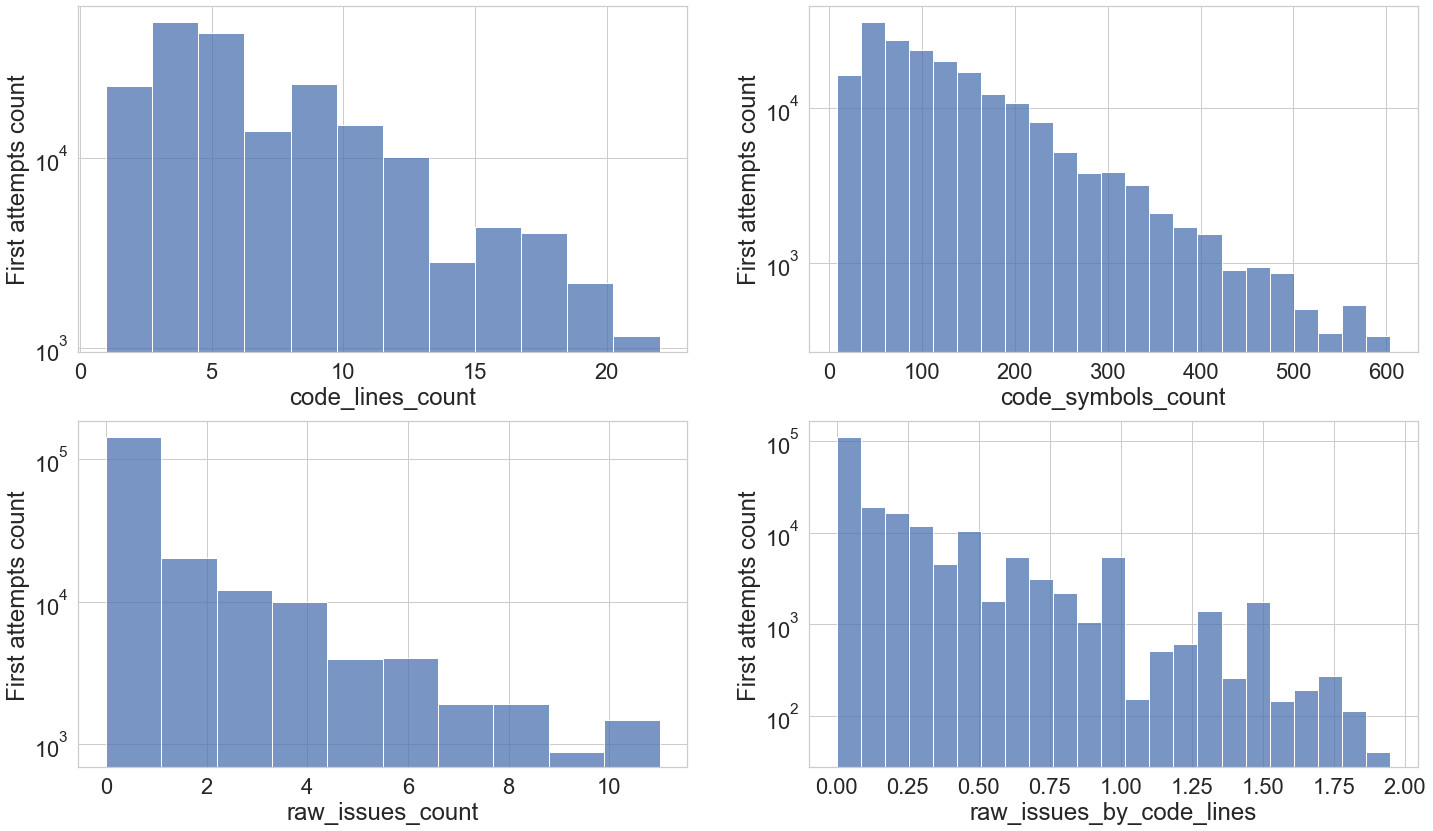

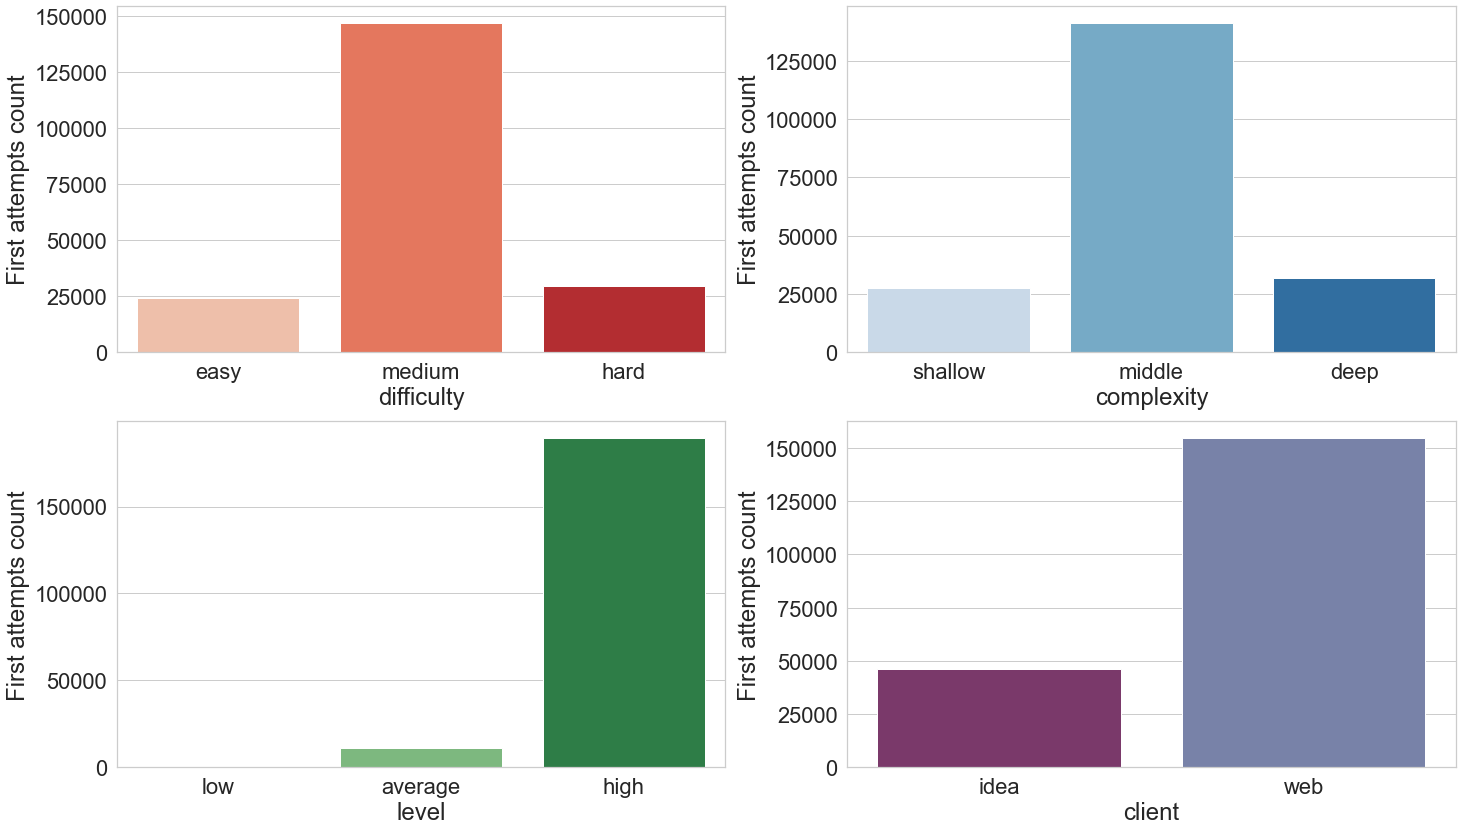

In [71]:
draw_hist_plots(df_first_attempt_stats, ['code_lines_count', 'code_symbols_count', 
                                       'raw_issues_count', 'raw_issues_by_code_lines'], 
                log_scale=(False, True), y_label='First attempts count')

draw_count_plots(df_first_attempt_stats, ['difficulty', 'complexity', 'level', 'client'], y_label='First attempts count')

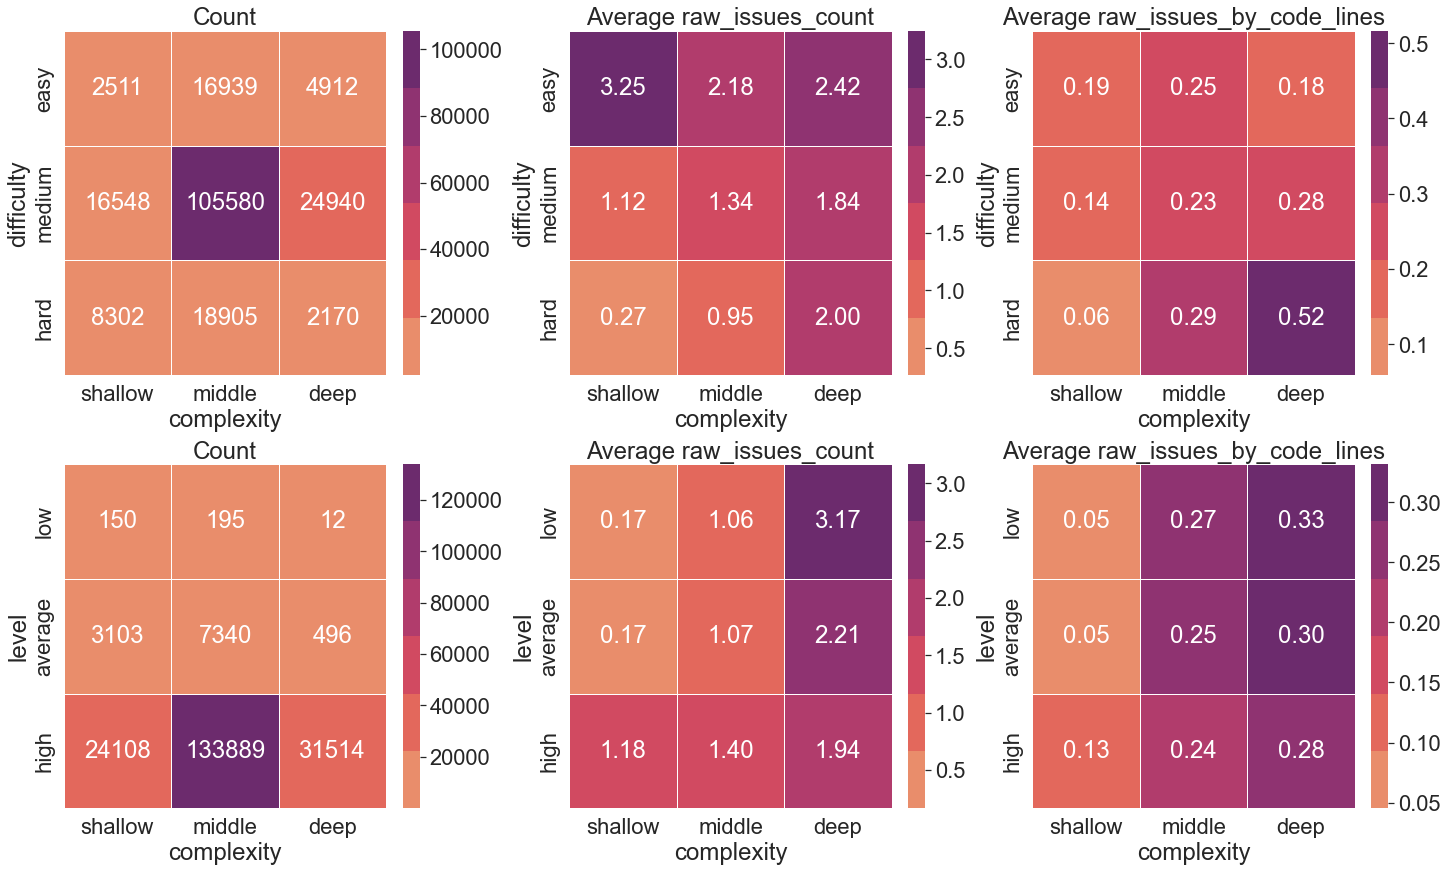

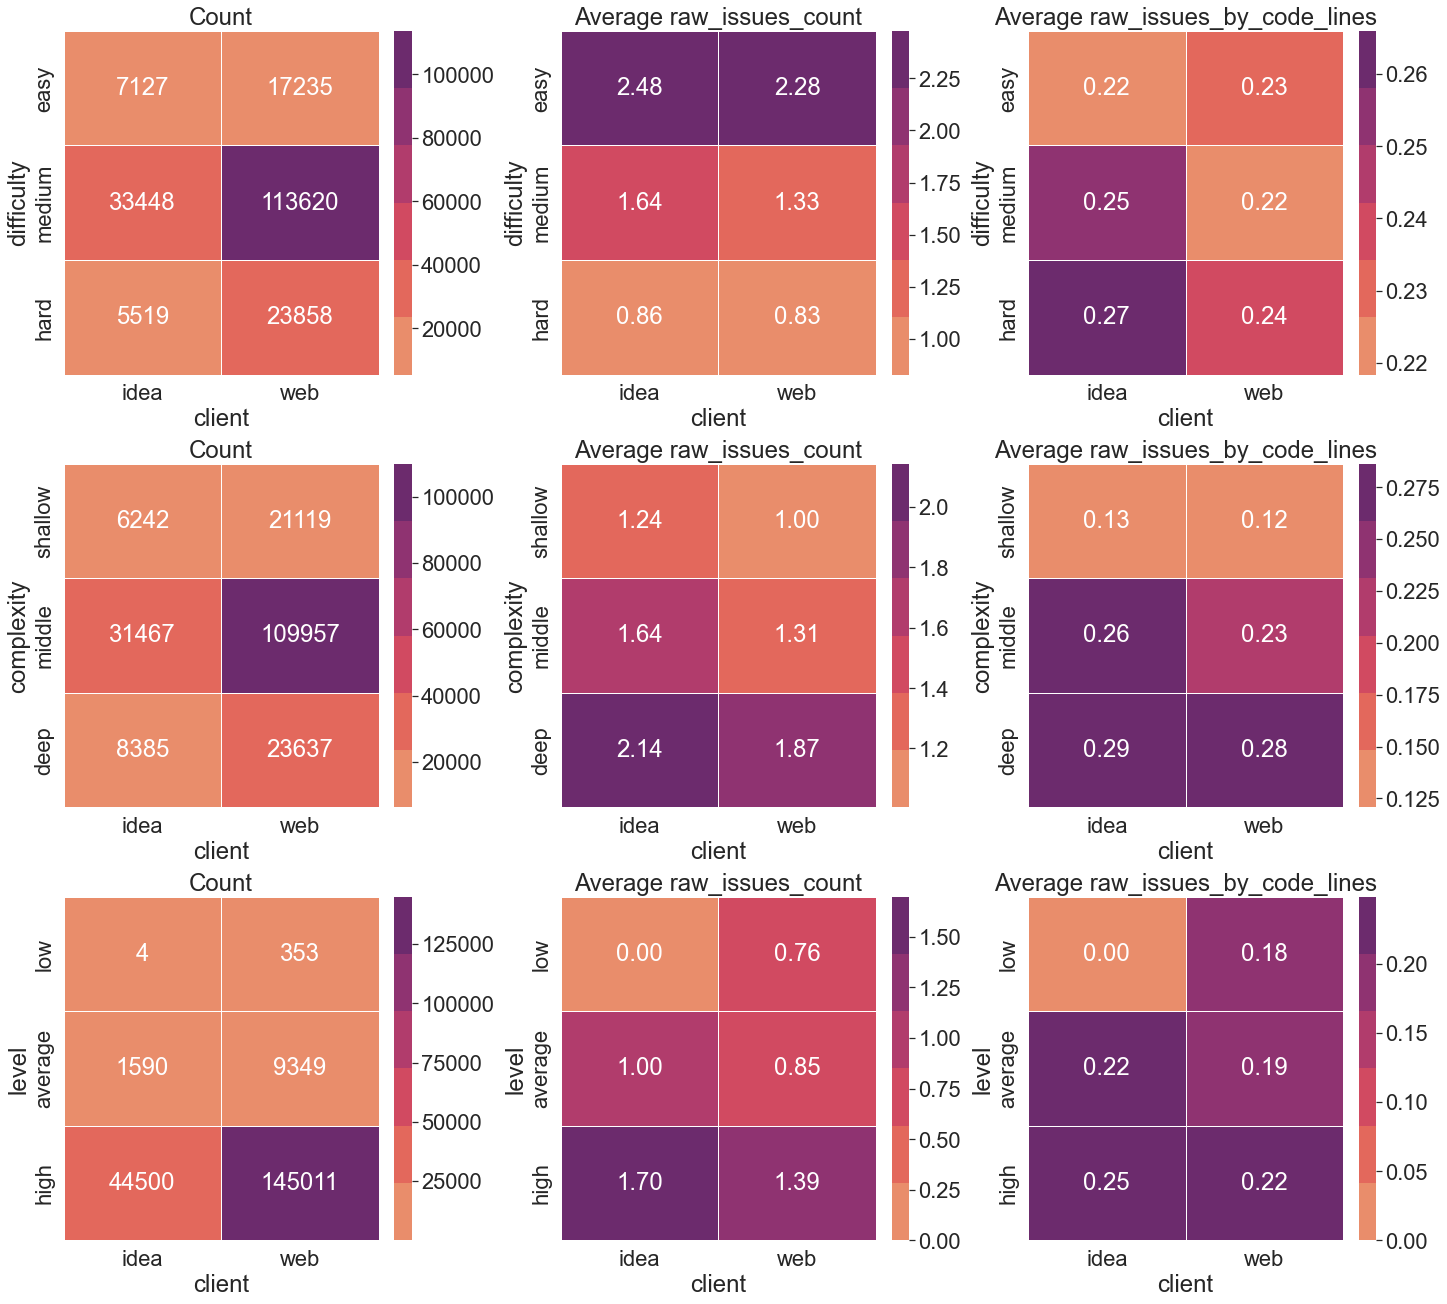

In [72]:
draw_heatmap_compare(df_first_attempt_stats, 
                     [('difficulty', 'complexity'), ('level', 'complexity')],
                     ['id', 'raw_issues_count', 'raw_issues_by_code_lines'])
draw_heatmap_compare(df_first_attempt_stats,
                     [('difficulty', 'client'), ('complexity', 'client'), ('level', 'client')],
                     ['id', 'raw_issues_count', 'raw_issues_by_code_lines'])

### First attempt issues statistics

In [73]:
df_first_attempt_raw_issues_stats = merge_dfs(df_first_attempt_stats, df_raw_issues_stats, left_on='id', right_on='id')
df_first_attempt_raw_issues_stats_unique = merge_dfs(df_first_attempt_stats, df_raw_issues_stats_unique, left_on='id', right_on='id')


### Percent of submissions with each issue class (first attempt)

### Raw issues

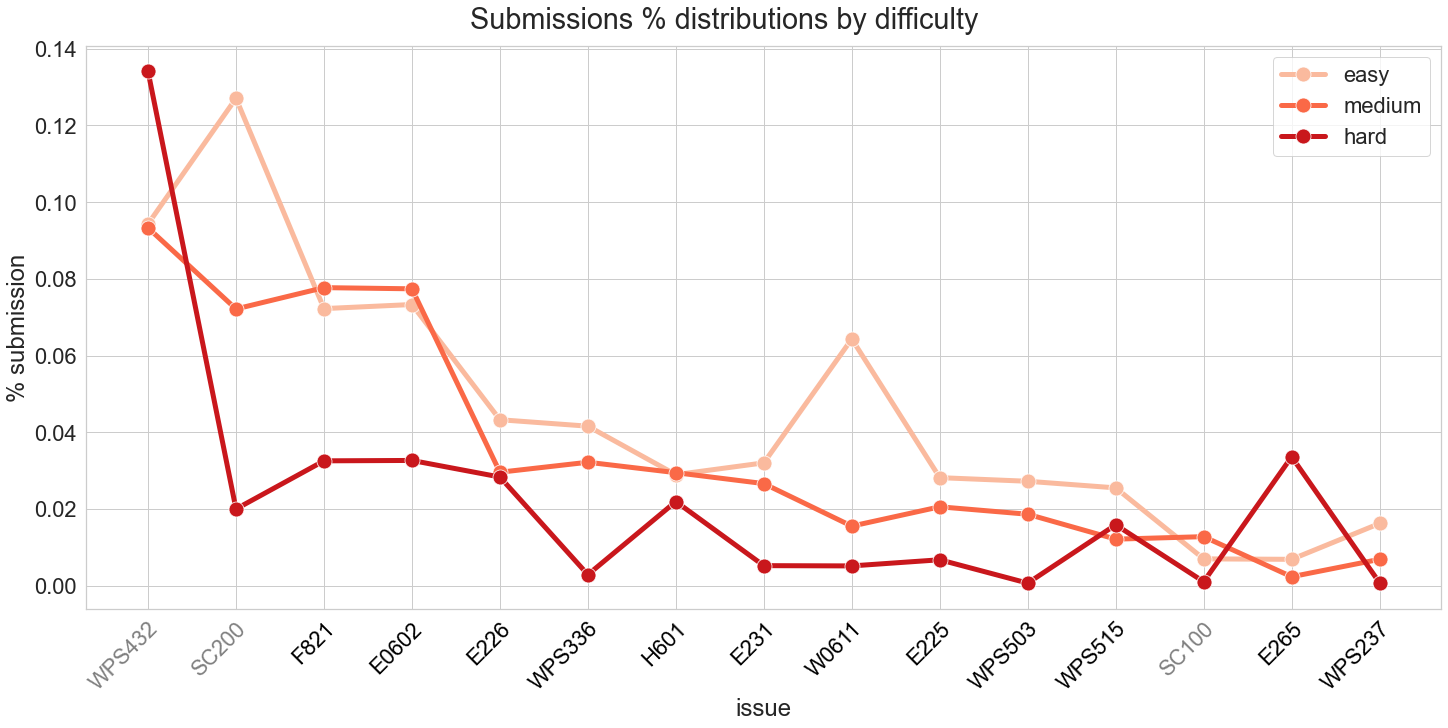

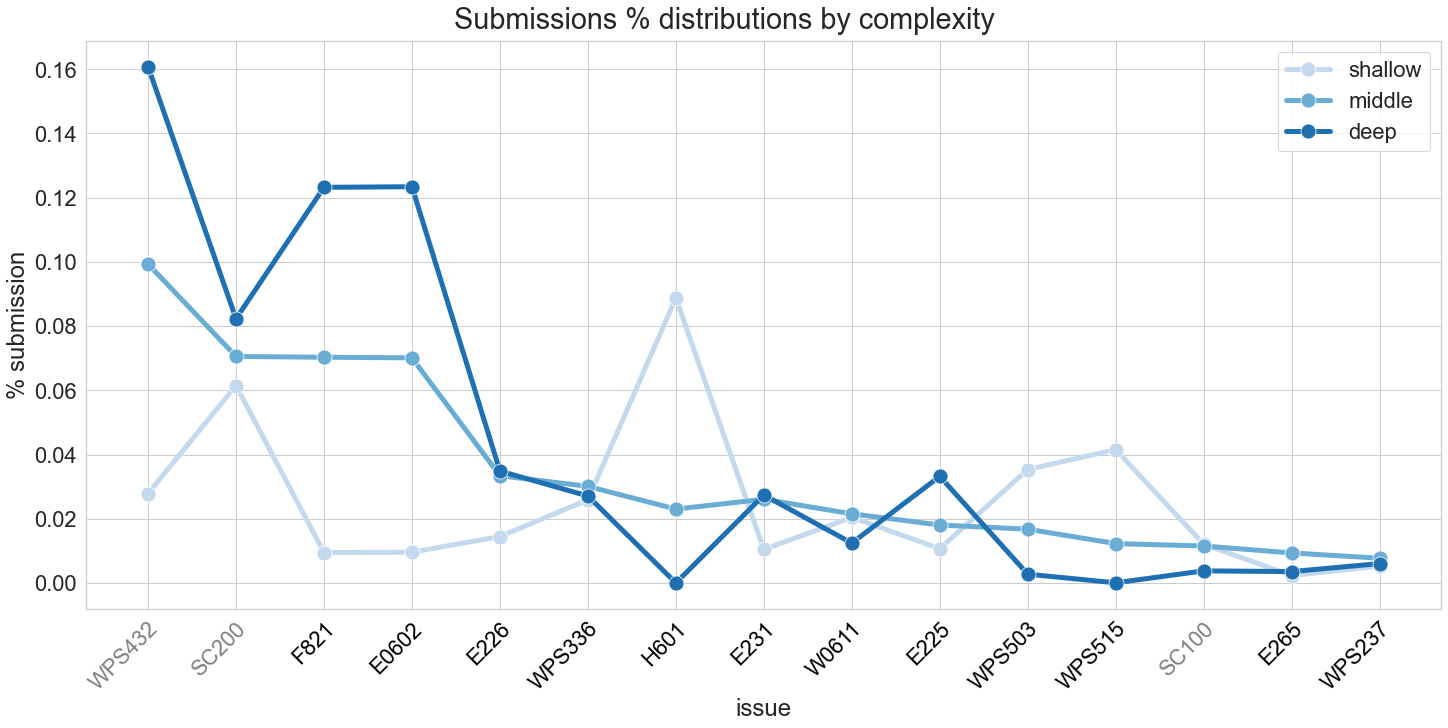

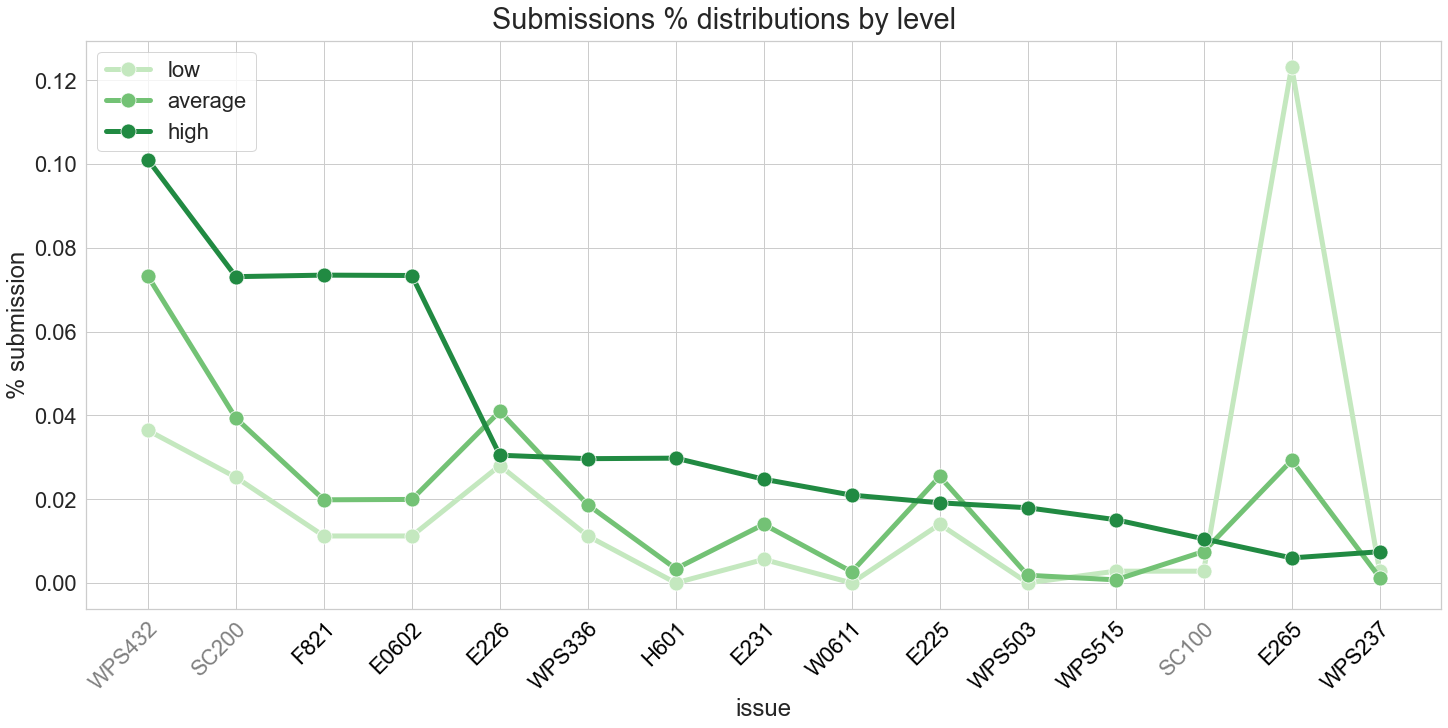

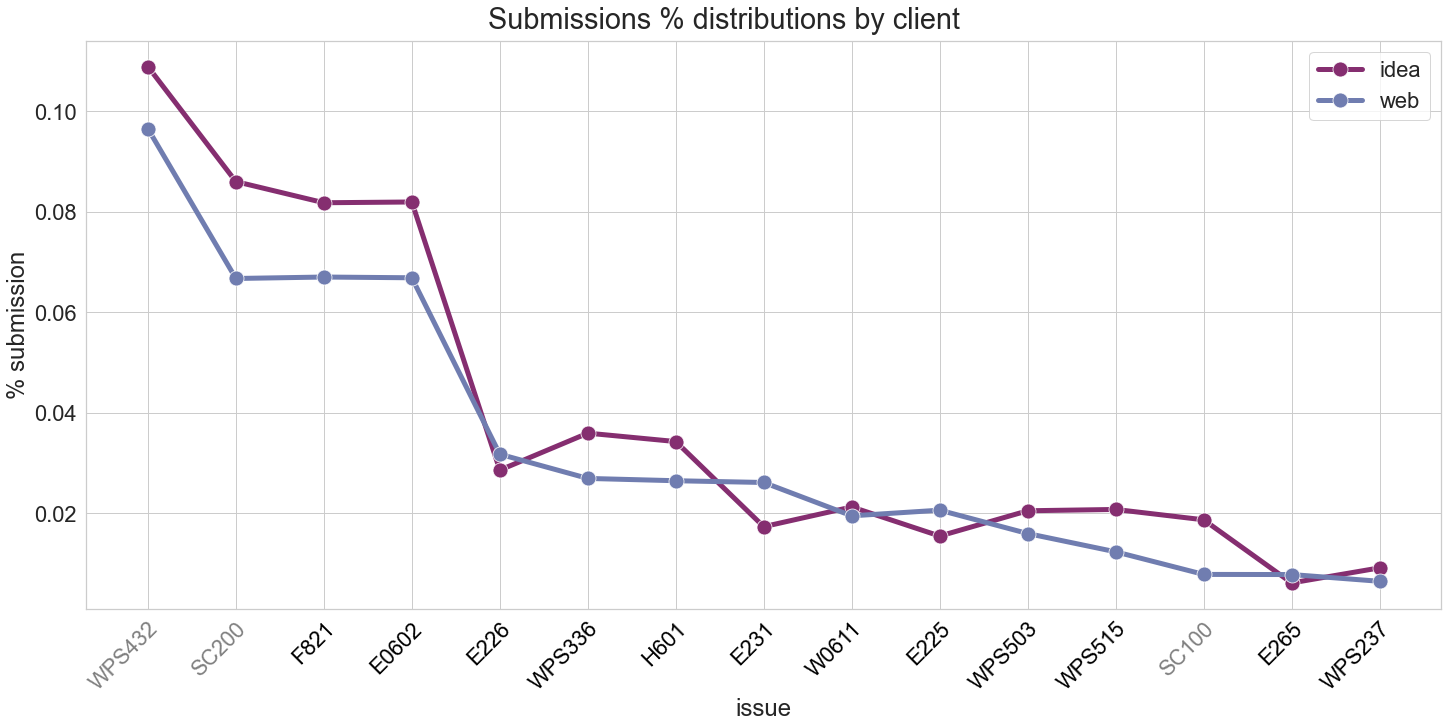

In [74]:
draw_issues(df_first_attempt_raw_issues_stats_unique, df_raw_issues_top, raw_issues_info_classes)

# Last attempt stats

Last attempt submissions is when **attempt** == **total_attemps** - final result of all attemps

In [75]:
df_last_attempt_stats = df_submissions_stats[df_submissions_stats['attempt'] == df_submissions_stats['total_attempts']]
df_last_attempt_stats.describe()

id  code_symbols_count  qodana_issues_count  \
count  2.008070e+05       200807.000000        200807.000000   
mean   4.245580e+07          139.673184             0.006608   
std    7.722757e+06          127.507396             0.090158   
min    2.938152e+07            8.000000             0.000000   
25%    3.549945e+07           57.000000             0.000000   
50%    4.232125e+07          106.000000             0.000000   
75%    4.935426e+07          180.000000             0.000000   
max    5.639778e+07         3264.000000            11.000000   

       raw_issues_count  code_lines_count        step_id        attempt  \
count     200807.000000     200807.000000  200807.000000  200807.000000   
mean           1.252212          6.755342    7731.092442       1.509723   
std            2.450255          4.728176    1693.118665      16.389206   
min            0.000000          1.000000    5205.000000       1.000000   
25%            0.000000          4.000000    6542.000000       1.000000   
50%            0.000000          6.000000    7173.000000       1.000000   
75%            2.000000          9.000000    8812.000000       1.000000   
max           81.000000         89.000000   15247.000000    3359.000000   

        sync_counter        user_id         group  total_attempts  \
count  200807.000000  200807.000000  2.008070e+05   200807.000000   
mean        4.707206   14314.986953  1.044451e+05        1.509723   
std         0.972205   11916.221152  8.657515e+04       16.389206   
min         2.000000       2.000000  0.000000e+00        1.000000   
25%         4.000000    4009.000000  5.027450e+04        1.000000   
50%         5.000000   11506.000000  1.012660e+05        1.000000   
75%         5.000000   21121.000000  1.519505e+05        1.000000   
max        19.000000   82097.000000  1.722217e+06     3359.000000   

       raw_issues_by_code_lines  qodana_issues_by_code_lines  
count             200807.000000                200807.000000  
mean                   0.201958                     0.006608  
std                    0.391082                     0.090158  
min                    0.000000                     0.000000  
25%                    0.000000                     0.000000  
50%                    0.000000                     0.000000  
75%                    0.250000                     0.000000  
max                   10.000000                    11.000000

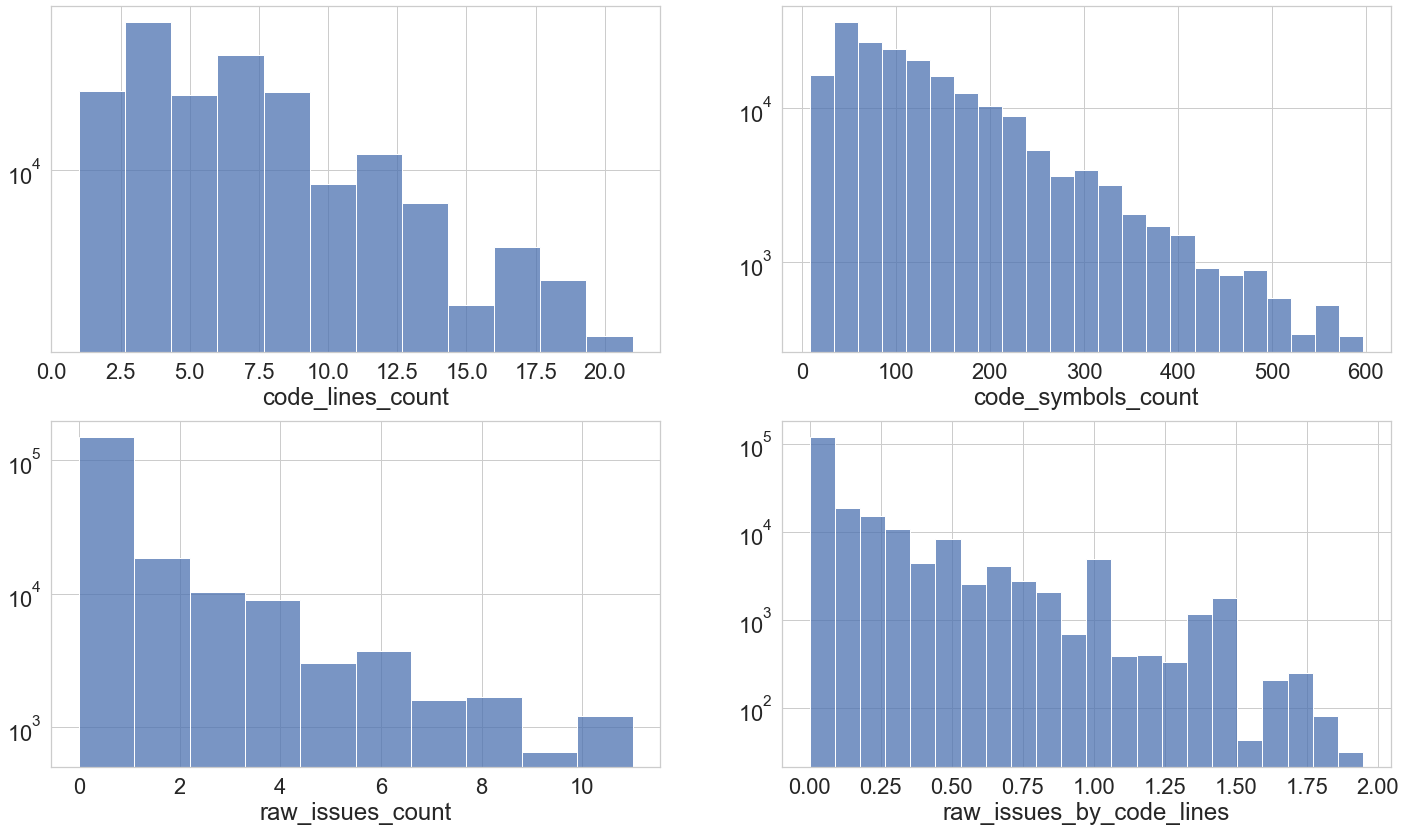

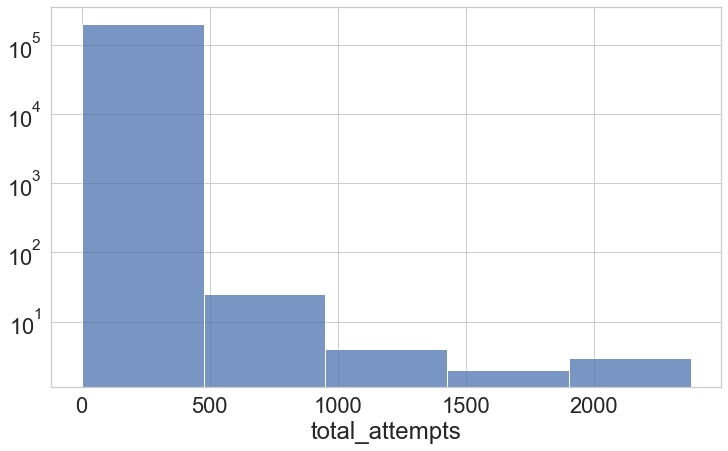

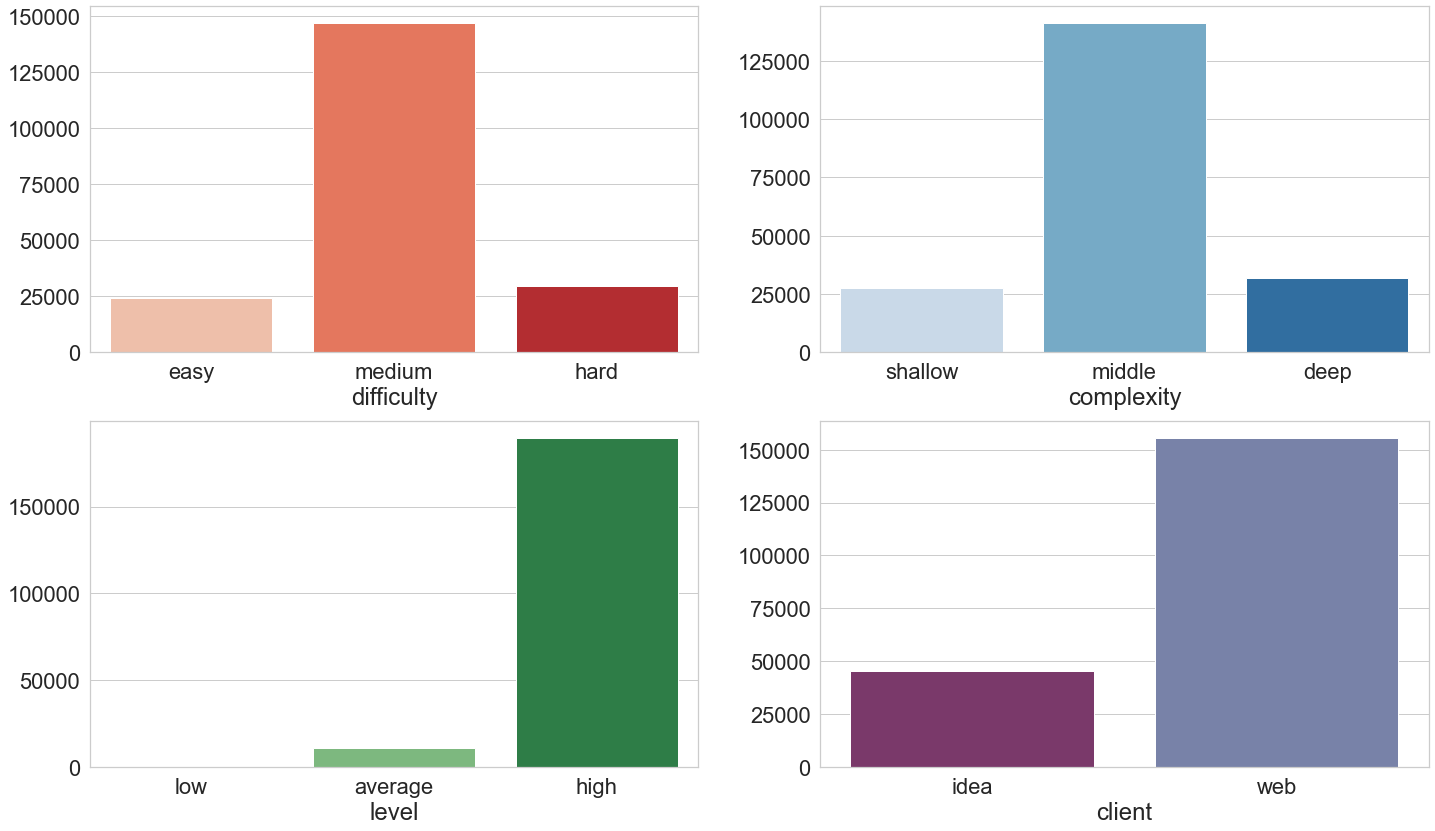

In [76]:
draw_hist_plots(df_last_attempt_stats, ['code_lines_count', 'code_symbols_count', 
                                       'raw_issues_count', 'raw_issues_by_code_lines'], 
                log_scale=(False, True))
draw_hist_plots(df_last_attempt_stats, ['total_attempts'], log_scale=(False, True), q=1, bins=5)
draw_count_plots(df_last_attempt_stats, ['difficulty', 'complexity', 'level', 'client'])

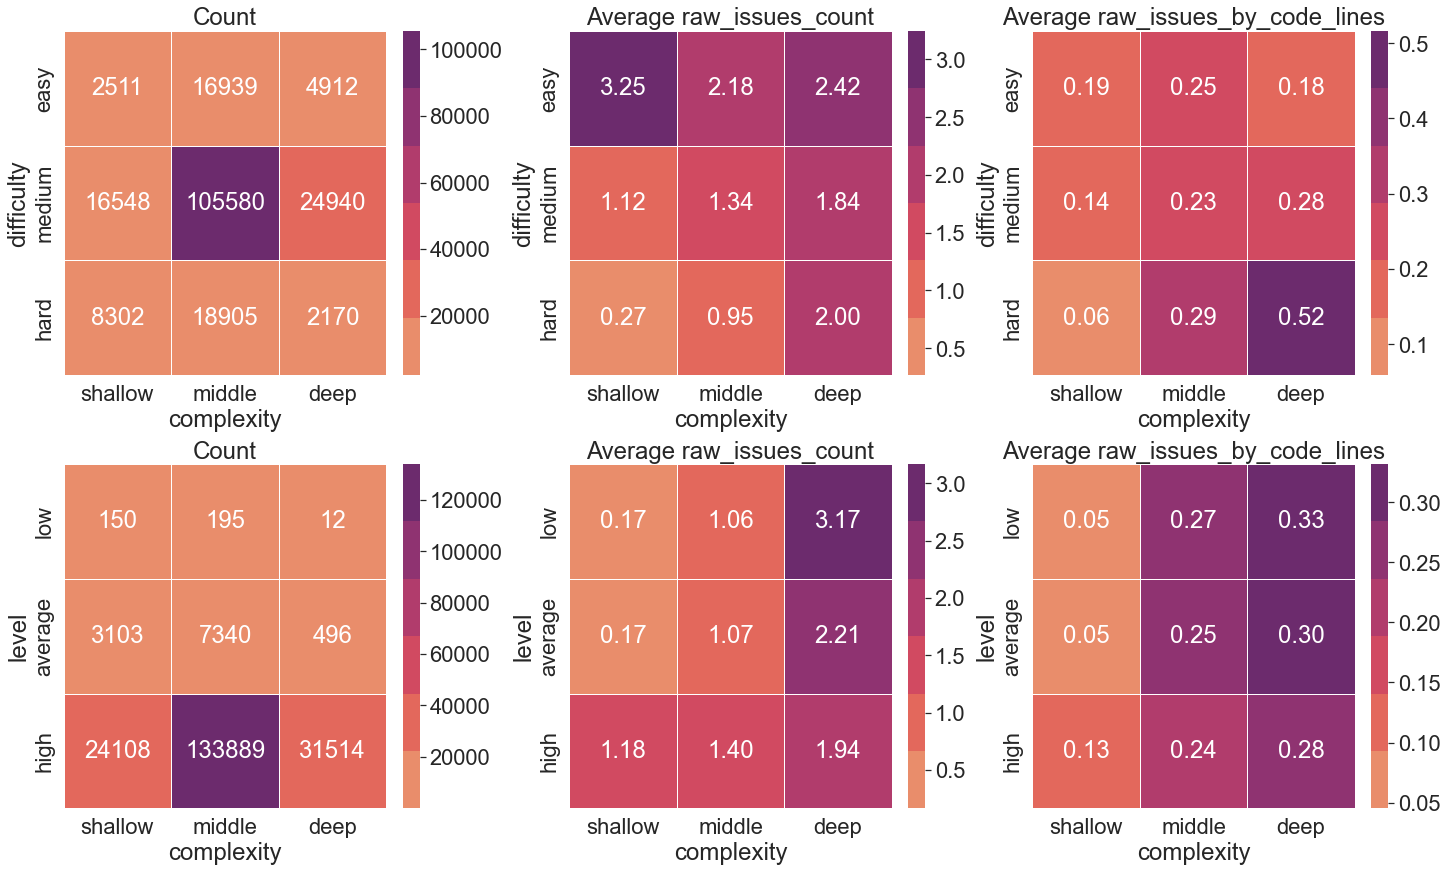

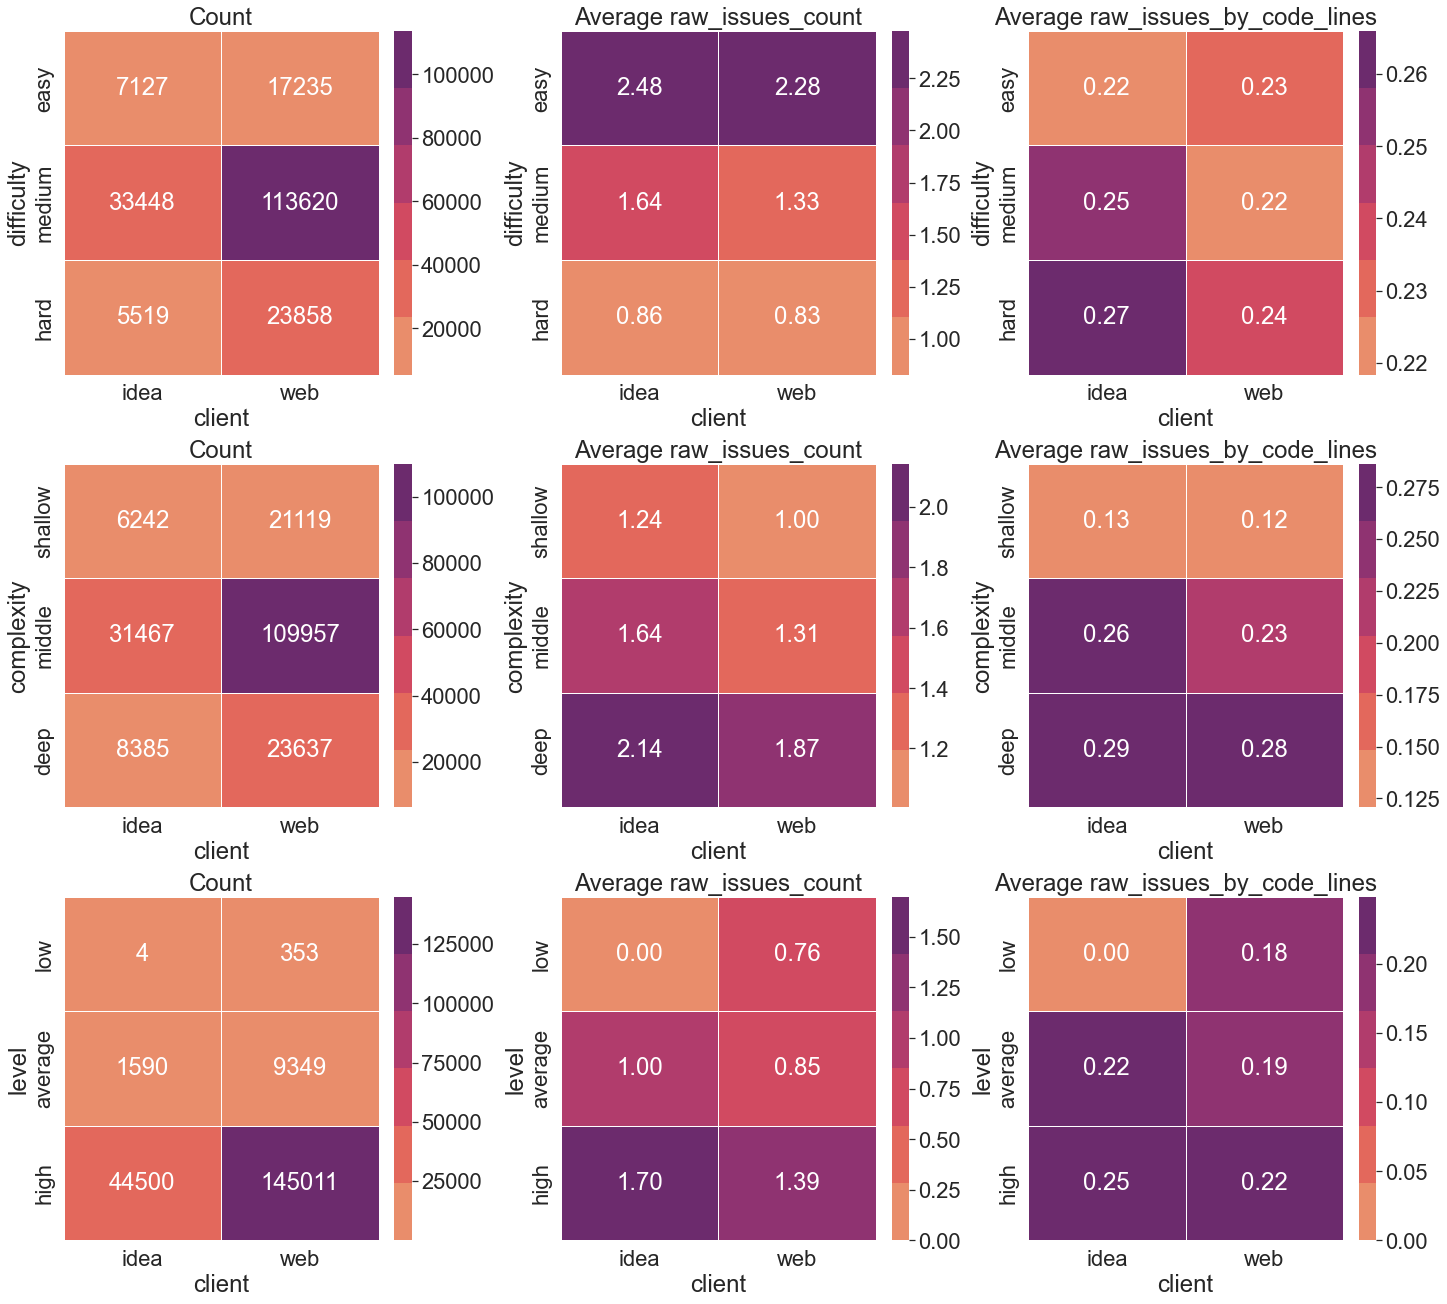

In [77]:
draw_heatmap_compare(df_first_attempt_stats, 
                     [('difficulty', 'complexity'), ('level', 'complexity')],
                     ['id', 'raw_issues_count', 'raw_issues_by_code_lines'])
draw_heatmap_compare(df_first_attempt_stats,
                     [('difficulty', 'client'), ('complexity', 'client'), ('level', 'client')],
                     ['id', 'raw_issues_count', 'raw_issues_by_code_lines'])

### Last attempt issues statistics

In [78]:
df_last_attempt_raw_issues_stats = merge_dfs(df_last_attempt_stats, df_raw_issues_stats, left_on='id', right_on='id')
df_last_attempt_raw_issues_stats_unique = merge_dfs(df_last_attempt_stats, df_raw_issues_stats_unique, left_on='id', right_on='id')

### Percent of submissions with each issue class (last attempt)

### Raw issues

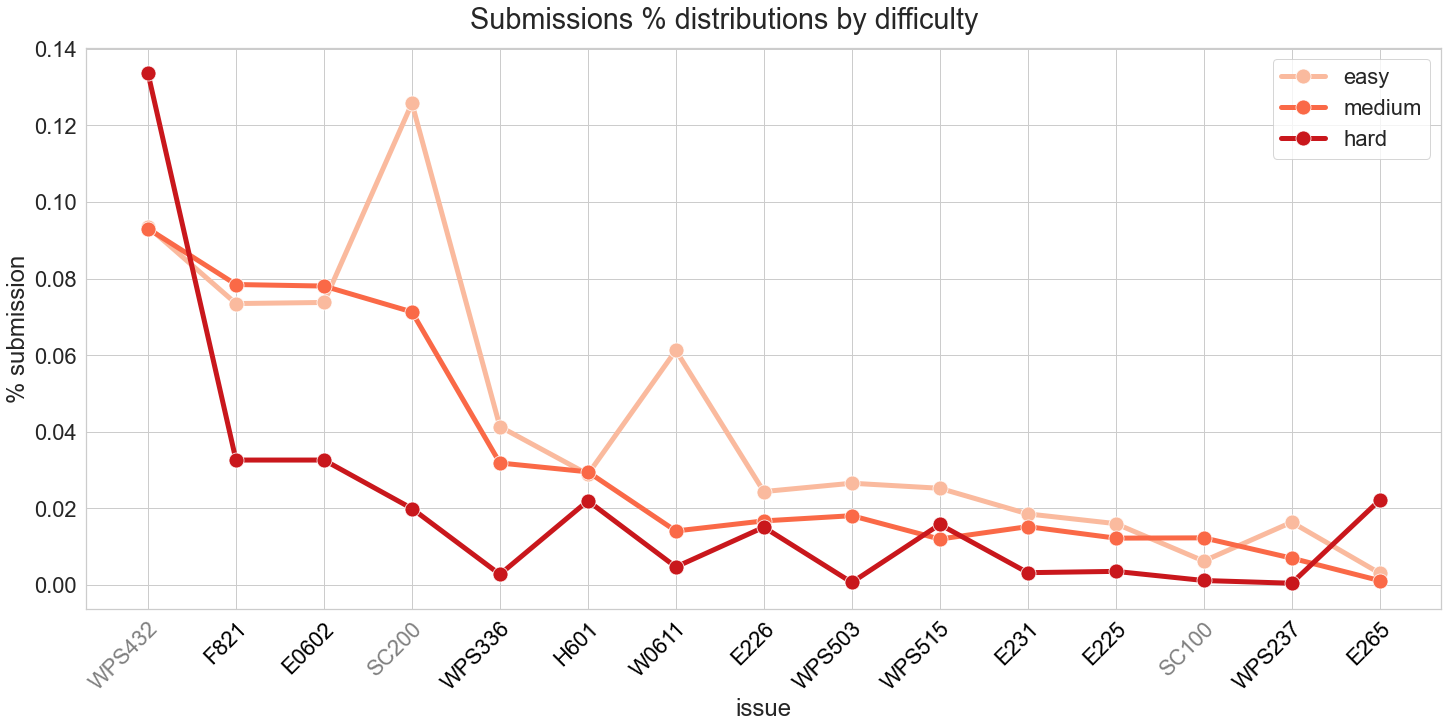

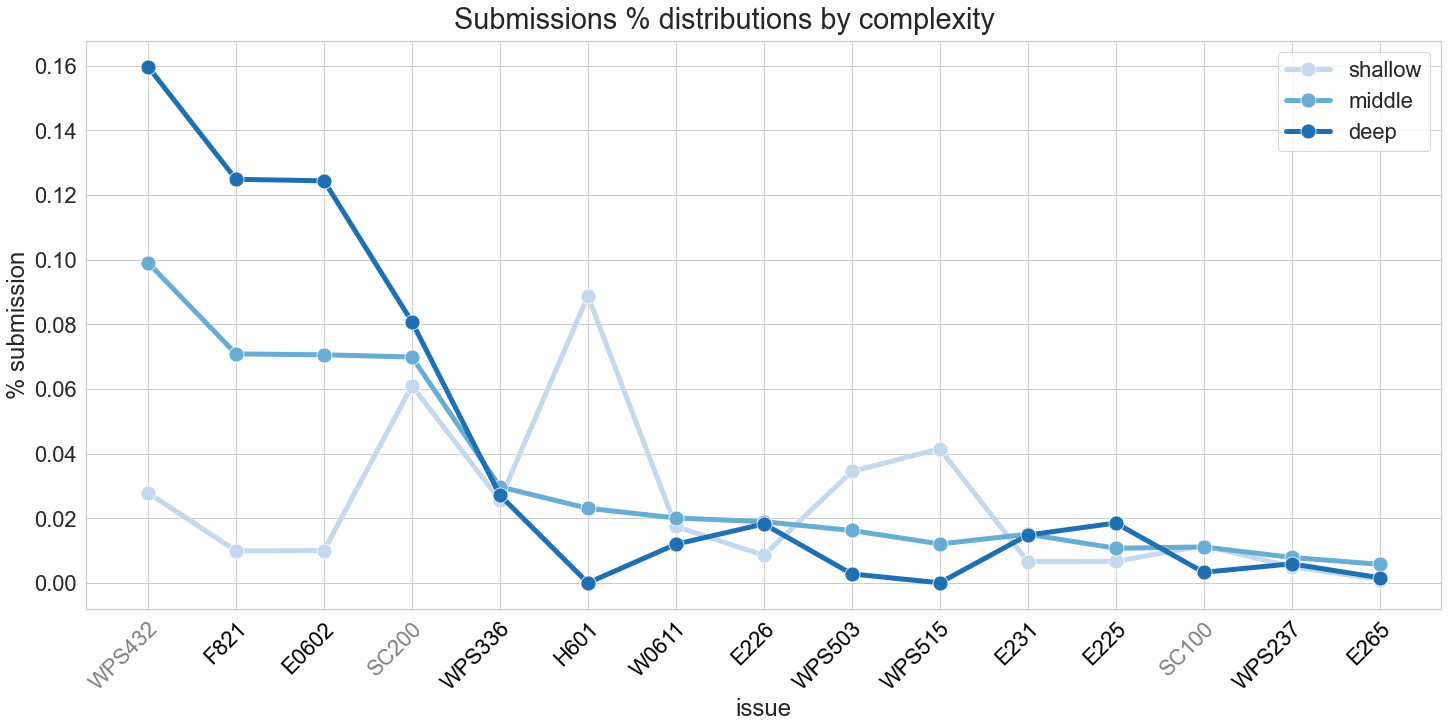

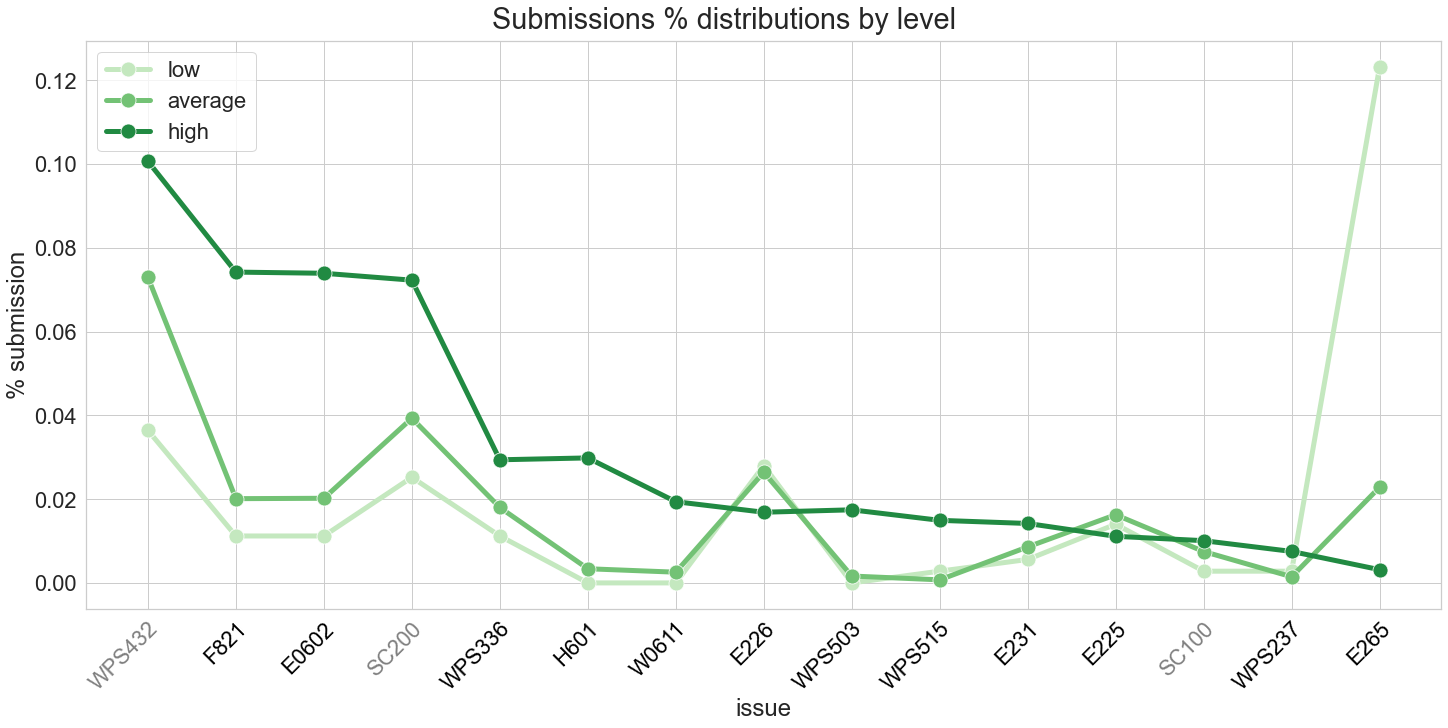

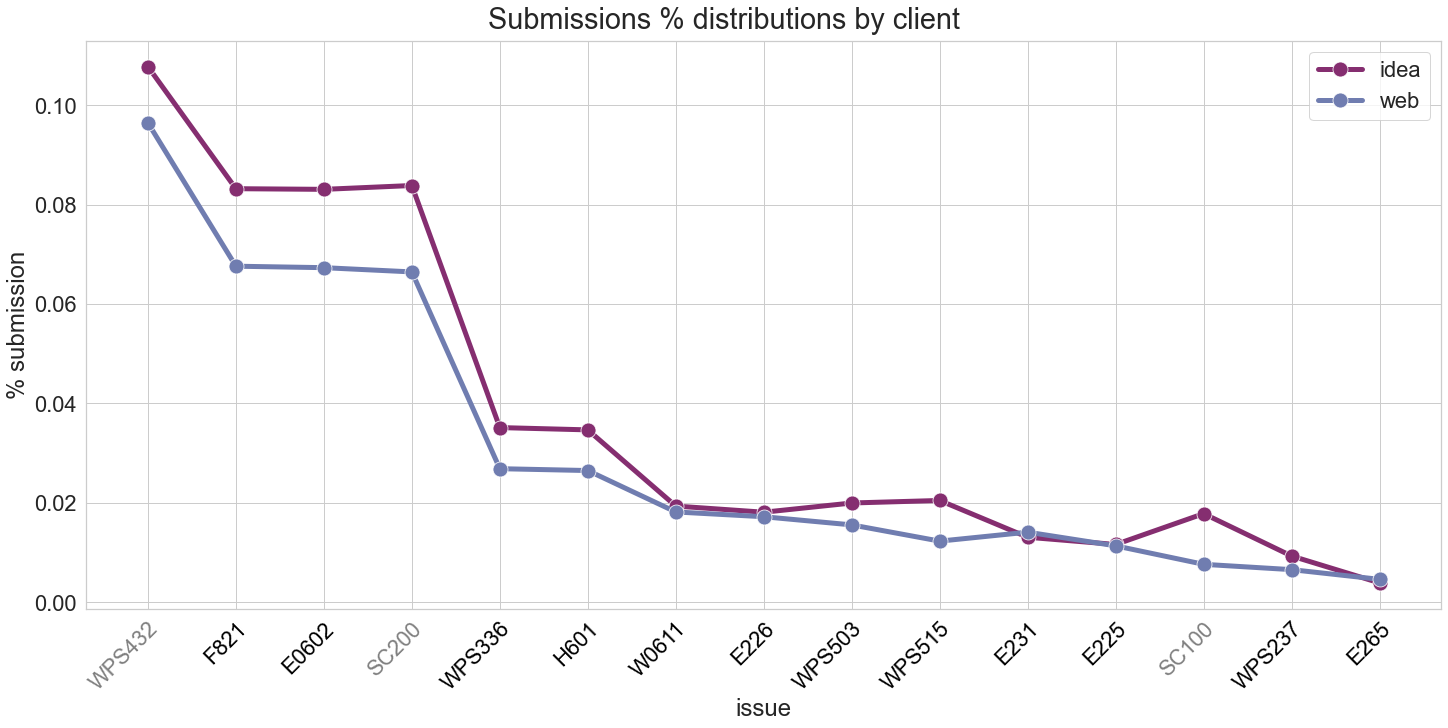

In [79]:
draw_issues(df_last_attempt_raw_issues_stats_unique, df_raw_issues_top, raw_issues_info_classes)

## Client statistics
Client is the interface where student implement step's task. Following section contains client popularity and change throught attemps analysis.

In [82]:
df_client_stats = pd.read_csv(client_stats_file_path)
df_client_stats['client_series'] = df_client_stats['client']

In [83]:
df_last_attempt_stats = merge_dfs(df_last_attempt_stats, df_client_stats, left_on='group', right_on='group')

In [84]:
df_last_attempt_client_stats = get_client_stats(df_last_attempt_stats)
df_last_attempt_client_stats

client_series  total_attempts   count
278                                            ["web"]               1  135457
245                                           ["idea"]               1   40147
277                                     ["web", "web"]               2   14390
226                                   ["idea", "idea"]               2    3539
276                              ["web", "web", "web"]               3    3021
..                                                 ...             ...     ...
86   ["idea", "idea", "idea", "idea", "idea", "idea...             173       1
87   ["idea", "idea", "idea", "idea", "idea", "idea...             170       1
90   ["idea", "idea", "idea", "idea", "idea", "idea...             162       1
91   ["idea", "idea", "idea", "idea", "idea", "idea...             157       1
139  ["idea", "idea", "idea", "idea", "idea", "idea...              74       1

[279 rows x 3 columns]

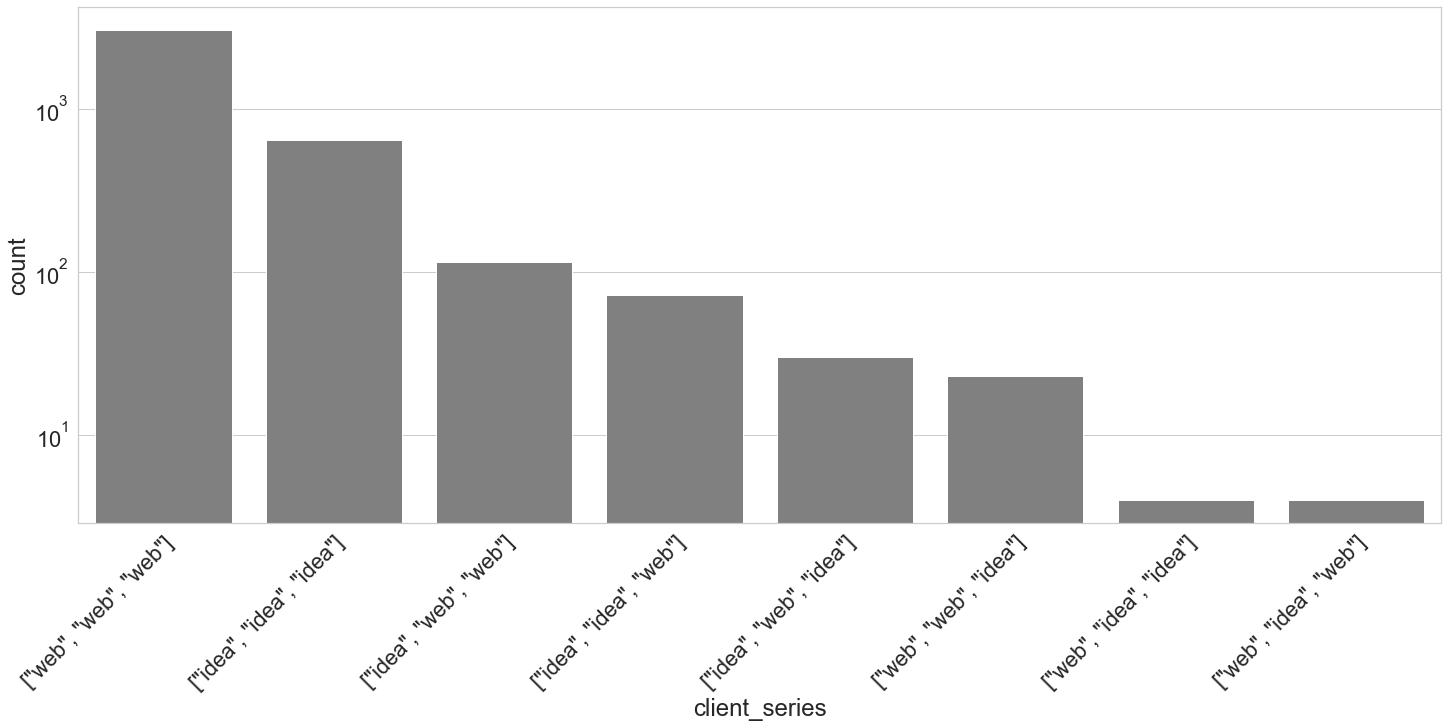

In [85]:
draw_stat_plot(df_last_attempt_stats[df_last_attempt_stats['total_attempts'] == 3], 'client_series')

In [86]:
df_client_dinamic = get_submissions_series_client_dynamic(
    df_last_attempt_client_stats[df_last_attempt_client_stats['total_attempts'] == 3])
df_client_dinamic

attempt  from    to  count
0         1  idea  idea    718
1         1  idea   web    144
2         1   web  idea      8
3         1   web   web   3044
4         2  idea  idea    650
5         2  idea   web     76
6         2   web  idea     53
7         2   web   web   3135
8         3  idea  idea      0
9         3  idea   web      0
10        3   web  idea      0
11        3   web   web      0

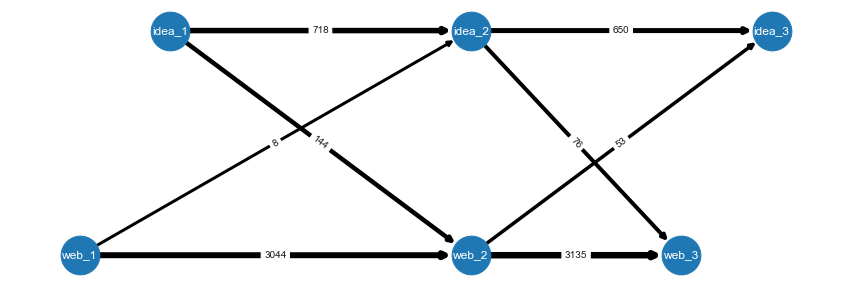

In [87]:
draw_client_dynamic_graph(df_client_dinamic)

# Submission series (groups)
To pass the step user can make several attemps. The ordered sequence of attemps in **submission series**

In [88]:
def draw_feature_dynamic(feature: str, max_attempts: int = 3, exact_attempts: bool = True, is_mean=True):
    for attr in ['difficulty', 'complexity', 'level', 'client']:
        df_dynamic = get_submissions_series_dynamic_by_feature(df_submissions_stats, feature, attr)
#         uncomment to save stats to csv
#         df_dynamic.to_csv(f'{feature}_dynamic_{attr}.csv', index=False)
        draw_compare(df_dynamic, 'attempt', attr, y_label=f'mean\n{feature}', title=f'{feature} dynamic by attemps')

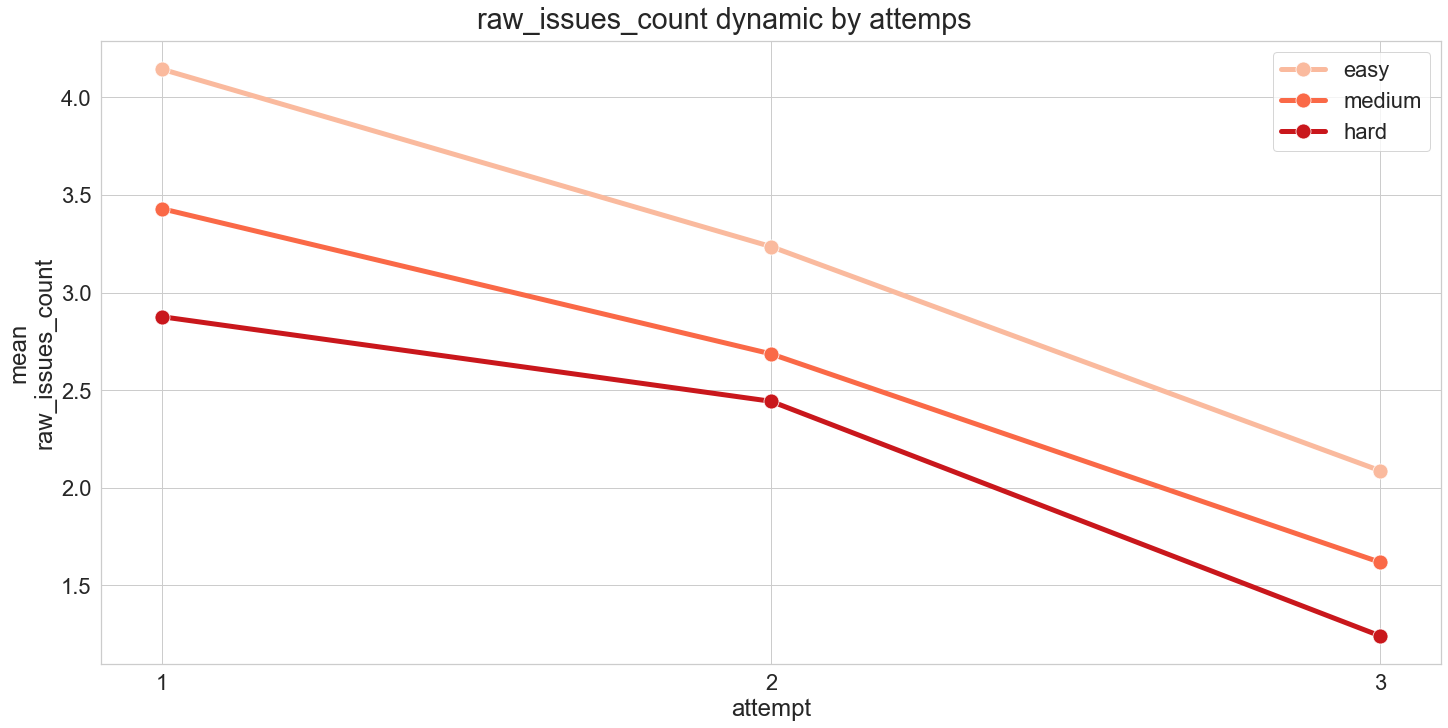

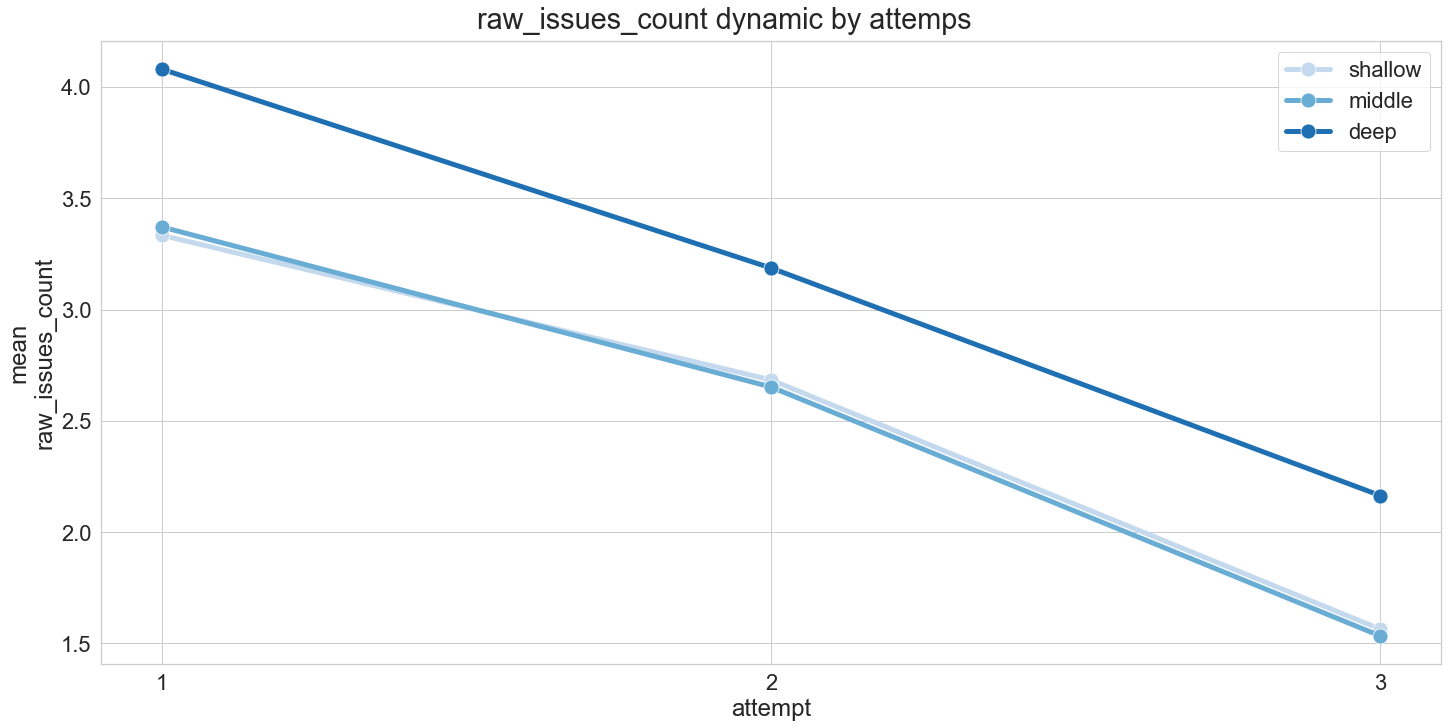

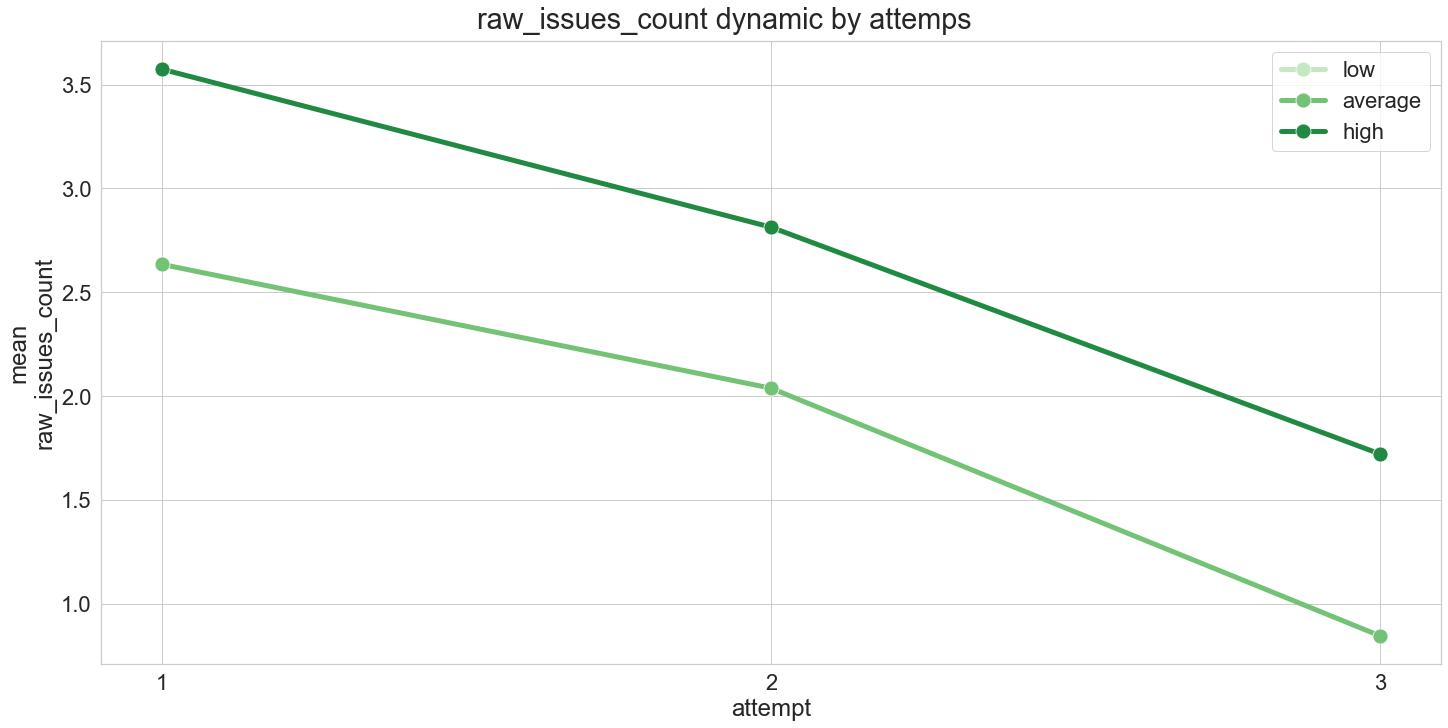

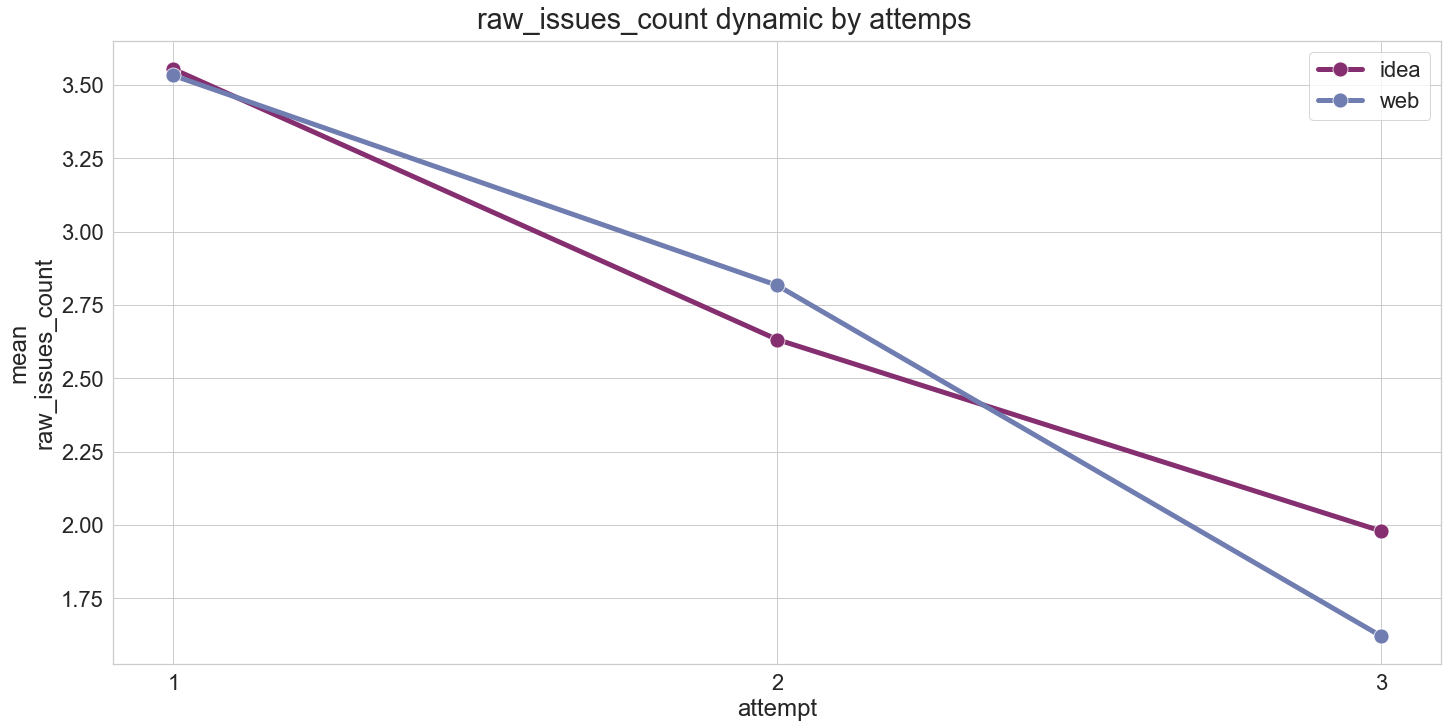

In [89]:
draw_feature_dynamic('raw_issues_count')

### Submissions series dynamic
Plots show how average soution parameters change throught attemps 

### Dynamin for all sobmission series with total_attemps = 3

In [90]:
def draw_issues_dynamic(df: pd.DataFrame, df_issues: pd.DataFrame, max_attempts: int = 3,
                                          exact_attempts: bool = True, by_type=False, is_mean=True):
    df_issues_dynamic = get_submissions_series_issues_dynamic(df, df_issues, 
                                                           max_attempts, exact_attempts, by_type, is_mean)
#     uncomment to save data to csv
#     df_issues_dynamic.to_csv(f'issues_dynamic.csv', index=False)
    issues = df_issues['type' if by_type else 'class'].unique()
    draw_compare(df_issues_dynamic, 'attempt', ('issue', issues))

### Raw issues

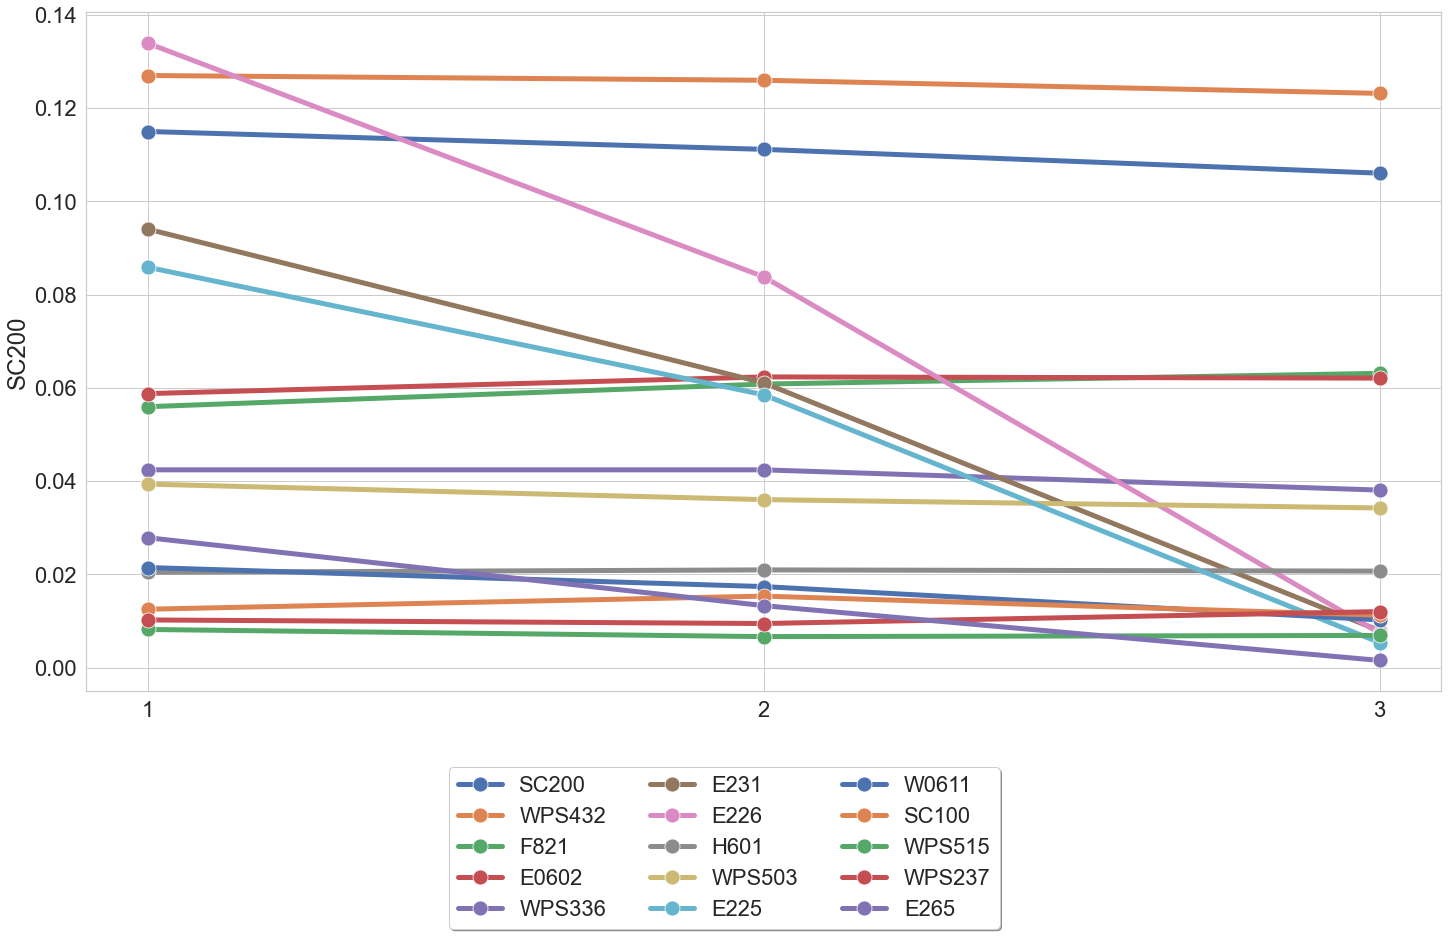

<Figure size 432x288 with 0 Axes>

In [91]:
draw_issues_dynamic(df_raw_issues_stats_unique, df_raw_issues_top)

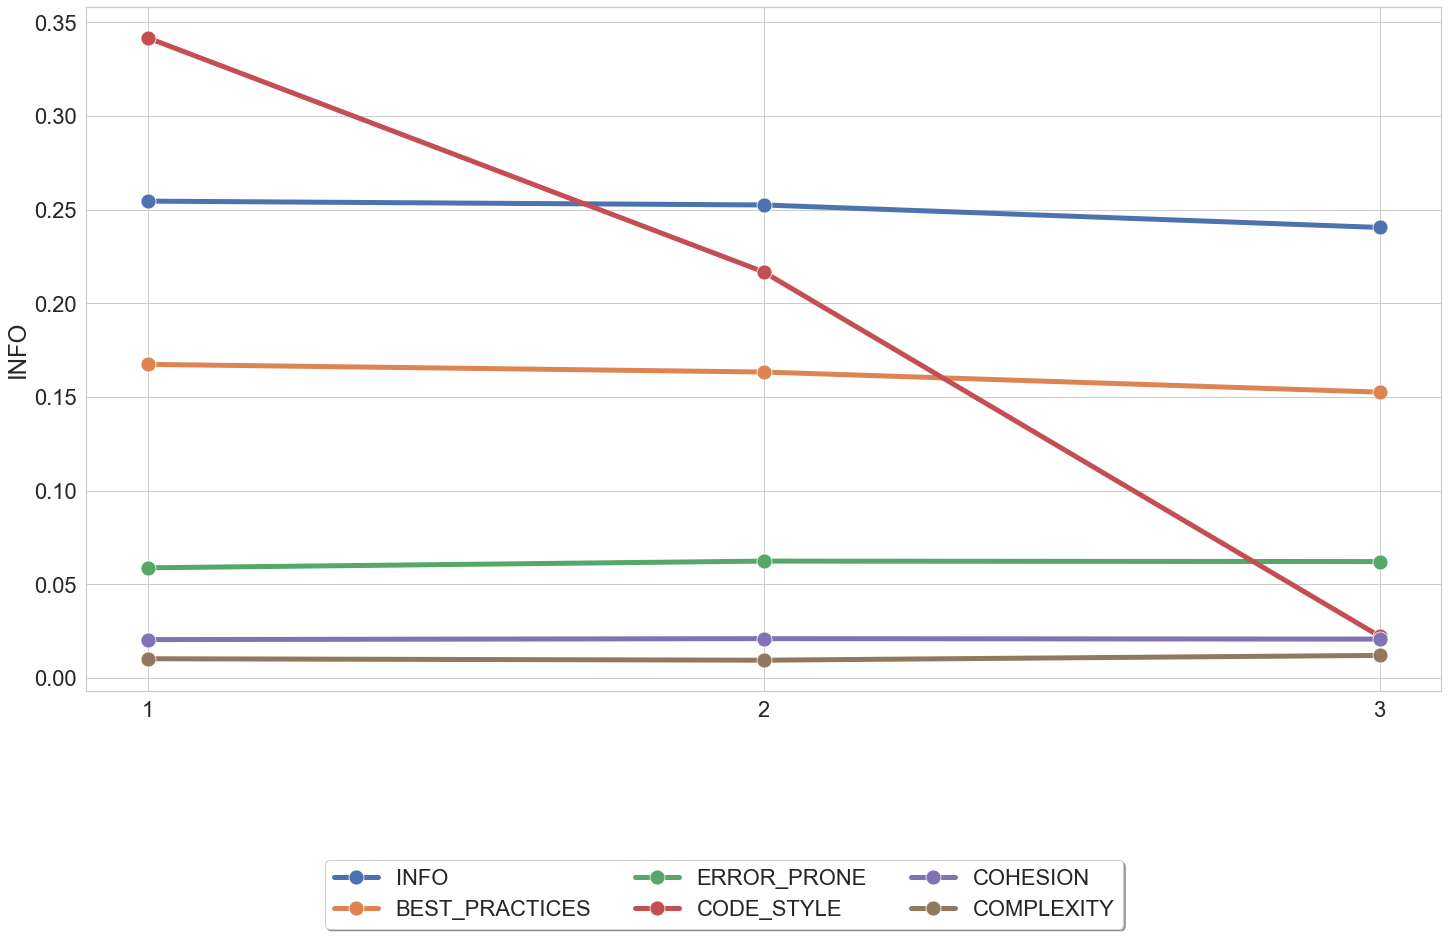

<Figure size 432x288 with 0 Axes>

In [92]:
draw_issues_dynamic(df_raw_issues_stats_unique, df_raw_issues_top, by_type=True)